# Initialize Functions

In [ ]:
#Naming conventions
#unod represents unod3d and unod2d does not exist due to one node indexing system; always a 1d vector
#u2d and u3d represent uele2d and uele3d in short; each has four columns (first as field; rest as gradient vector)

#Unsolved
#1.distance scaling factor does not work for coupled problems
#2.set_first_kind_bc needs to be updated to accomendate more rows in K
#3.update with_first_kind_bc with the size of faces/edges in 3D implementation
#4.declare numpy type explicitly for function input/output variables

## Main functions

In [121]:
%reset -f

import copy,h5py,time
import numpy as np
import numpy.matlib
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.linalg import block_diag

#set physicsical constants
echarge=1.602e-19 #elementary charge [C]
perm0=8.85e-12 #vacuum permittivity [F/m]
kA=6.022e23 #Avogadro constant [1/mol]
kB=1.381e-23 #Boltzmann's constant [J/K]

def system_check():
    print('Run system check')
    print('Default numpy.int is %d bits'%np.iinfo(int).bits)
    print('Default numpy.float is %d bits'%np.finfo(float).bits)
    print('')
    return

def import_mesh(infile):
    print('Reading group mesh from %s'%infile)
    with h5py.File(infile,'r') as file:
        nodes=np.array(file['mesh/nodes']).astype(float)
        elements=np.array(file['mesh/elements']).astype(int)
        faces=np.array(file['mesh/faces']).astype(int)
        
        in_active_zones=np.array(file['mesh/in_active_zones']).astype(bool)
        with_first_kind_bc=np.array(file['mesh/with_first_kind_bc']).astype(bool)
        with_third_kind_bc=np.array(file['mesh/with_third_kind_bc']).astype(bool)

        in_electrolyte=np.array(file['mesh/in_electrolyte']).astype(bool)
        in_solid=np.array(file['mesh/in_solid']).astype(bool)
        in_stern=np.array(file['mesh/in_stern']).astype(bool)

    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')

    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}

    return mesh

def import_physics(infile):
    print('Reading group physics from %s'%infile)
    with h5py.File(infile,'r') as file:
        rel_perm_electrolyte=np.array(file['physics/rel_perm_electrolyte']).astype(float)
        rel_perm_solid=np.array(file['physics/rel_perm_solid']).astype(float)
        diffusion_electrolyte=np.array(file['physics/diffusion_electrolyte']).astype(float)
        diffusion_stern=np.array(file['physics/diffusion_stern']).astype(float)
        mobility_electrolyte=np.array(file['physics/mobility_electrolyte']).astype(float)
        mobility_stern=np.array(file['physics/mobility_stern']).astype(float)
        sigma_electrolyte=np.array(file['physics/sigma_electrolyte']).astype(float)
        sigma_stern=np.array(file['physics/sigma_stern']).astype(float)
        temp_K=np.array(file['physics/temperature']).astype(float)
        cinf=np.array(file['physics/ion_conc_inf']).astype(float)
        zval=np.array(file['physics/ion_val']).astype(float)

    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',sigma_electrolyte)
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',sigma_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')

    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_electrolyte':sigma_electrolyte,'sigma_stern':sigma_stern,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}

    return physics

def scale_mesh(mesh_in,dist_factor):
    print('Scaling distance in mesh')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    mesh=copy.deepcopy(mesh_in)
    mesh['nodes']=mesh['nodes']*dist_factor
    return mesh

def scale_materials(materials_in,dist_factor):
    print('Scaling distance in materials')
    print('DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    materials=copy.deepcopy(materials_in)

    materials['cx']=materials['cx']/1.0
    materials['cy']=materials['cy']/1.0
    materials['cz']=materials['cz']/1.0

    materials['alpha_x']=materials['alpha_x']/dist_factor
    materials['alpha_y']=materials['alpha_y']/dist_factor
    materials['alpha_z']=materials['alpha_z']/dist_factor

    materials['beta_x']=materials['beta_x']/dist_factor
    materials['beta_y']=materials['beta_y']/dist_factor
    materials['beta_z']=materials['beta_z']/dist_factor

    materials['gamma_x']=materials['gamma_x']/dist_factor
    materials['gamma_y']=materials['gamma_y']/dist_factor
    materials['gamma_z']=materials['gamma_z']/dist_factor

    materials['a']=materials['a']/dist_factor**2
    materials['f']=materials['f']/dist_factor**2
    materials['gs']=materials['gs']/dist_factor
    materials['qs']=materials['qs']/dist_factor
    materials['snod']=materials['snod']/1.0
    materials['anod']=materials['anod']/dist_factor**2
    materials['fnod']=materials['fnod']/dist_factor**2

    return materials

def grad2d(nodes,faces,unod,dist_factor,local):
    print('Computing fields and gradients on faces')
    start=time.time()

    nface=len(faces)
    u2d=np.zeros((nface,7),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nface): #consider parallelization
        nind=faces[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T

        Je[1:,:]=nodes_new[:,:-1].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes_new[:,0])/3
        yr=sum(nodes_new[:,1])/3
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])

        dudx=sum(unod[nind]*invJe[:,1])
        dudy=sum(unod[nind]*invJe[:,2])
        u2d[i,1:4]=[dudx,dudy,0]
        u2d[i,4:7]=np.linalg.inv(R).dot([dudx,dudy,0])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')

    if local:
        u2d=u2d[:,[0,1,2,3]]
    else:
        u2d=u2d[:,[0,4,5,6]]

    return u2d*dist_factor

def grad3d(nodes,elements,unod,dist_factor):
    print('Computing fields and gradients in elements')
    start=time.time()

    nelem=len(elements)
    u3d=np.zeros((nelem,4),dtype=complex)
    Je=np.ones((4,4))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=.25*sum(nodes[nind,0])
        yr=.25*sum(nodes[nind,1])
        zr=.25*sum(nodes[nind,2])
        u3d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr+invJe[:,3]*zr)*unod[nind])
        u3d[i,1]=sum(unod[nind]*invJe[:,1])
        u3d[i,2]=sum(unod[nind]*invJe[:,2])
        u3d[i,3]=sum(unod[nind]*invJe[:,3])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u3d*dist_factor

def rotate_triangle(nodes):
    A=np.zeros((3,3))
    R=np.zeros((3,3))

    xnod=nodes[:,0]
    ynod=nodes[:,1]
    znod=nodes[:,2]

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2

    n=n/np.linalg.norm(n)
    z=np.array([0,0,1])
    k=np.cross(n,z)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8: #consider improving this line
        k=k/norm_k

        cosb=np.dot(n,z)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)

    return R

def output_unod(nodes,unod,srvfile):
    output=np.genfromtxt(srvfile,skip_header=1)
    rec=output[:,1:4]
    for i in range(len(rec)):
        dist2=(rec[i,0]-nodes[:,0])**2+(rec[i,1]-nodes[:,1])**2+(rec[i,2]-nodes[:,2])**2
        nind=np.argmin(dist2)
        output[i,6]=np.real(unod[nind])
        output[i,7]=np.imag(unod[nind])

    outfile=srvfile+'.out'
    fmt='%d\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e\t%10.2e'
    print('Saving results to %s'%outfile)
    np.savetxt(outfile,output,header=str(len(output)),comments='',fmt=fmt)
    print('')
    return output

def assemble_Ke2d3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)

    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d3d(xnod,ynod,gamma_x=gamma_x[i],
                           gamma_y=gamma_y[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ks3d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern

    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d2d(xnod,ynod,znod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ke2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    faces_stern=mesh['faces'][in_stern,:]
    nnode=len(mesh['nodes'])
    nface_stern=len(faces_stern)

    cx=np.reshape(materials['cx'][in_stern],(nface_stern,nrep,nrep))
    cy=np.reshape(materials['cy'][in_stern],(nface_stern,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_stern],(nface_stern,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_stern],(nface_stern,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_stern],(nface_stern,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_stern],(nface_stern,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nface_stern,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_stern],(nface_stern,nrep))
    a=np.reshape(materials['a'][in_stern],(nface_stern,nrep,nrep))
    f=np.reshape(materials['f'][in_stern],(nface_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_stern*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_stern*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nface_stern):
        nind=faces_stern[i,:]
        R=rotate_triangle(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        ynod=nodes_new[:,1]
        Ke,be=build_Ke2d(xnod,ynod,cx=cx[i],cy=cy[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],
                         a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ke3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']

    nodes=mesh['nodes']
    elements_in=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_in=len(elements_in)

    cx=np.reshape(materials['cx'][in_active_zones],(nelem_in,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_in,nrep,nrep))
    cz=np.reshape(materials['cz'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_in,nrep,nrep))
    alpha_z=np.reshape(materials['alpha_z'][in_active_zones],(nelem_in,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_in,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_in,nrep,nrep))
    beta_z=np.reshape(materials['beta_z'][in_active_zones],(nelem_in,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_in,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_in,nrep))
    gamma_z=np.reshape(materials['gamma_z'][in_active_zones],(nelem_in,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_in,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_in,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_in*16*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_in*16*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(4*nrep),4*nrep,1).T
    COL=np.matlib.repmat(np.arange(4*nrep),4*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nelem_in):
        nind=elements_in[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ke,be=build_Ke3d(xnod,ynod,znod,cx=cx[i],cy=cy[i],cz=cz[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],alpha_z=alpha_z[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],beta_z=beta_z[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],gamma_z=gamma_z[i],
                         a=a[i],f=f[i],anod=anod[nind],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+16*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+16*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+16*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+16*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def assemble_Ks3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']

    nodes=mesh['nodes']
    faces_bc=mesh['faces'][with_third_kind_bc,:]
    nnode=len(nodes)
    nface_bc=len(faces_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nface_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nface_bc,nrep,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nface_bc*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nface_bc*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nface_bc):
        nind=faces_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        Ks,bs=build_Ks3d(xnod,ynod,znod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def set_first_kind_bc3d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1):
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    with_first_kind_bc=mesh['with_first_kind_bc']

    nodes=mesh['nodes']
    nodes_bc=mesh['nodes'][with_first_kind_bc]
    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    snod=np.reshape(materials['snod'][with_first_kind_bc],(nnode_bc,nrep))

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_bc=np.where(with_first_kind_bc)[0]
    nind_in=np.where(~with_first_kind_bc)[0]

    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes2d(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    faces=mesh['faces']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(faces[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=0

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]

    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes3d(mesh,K_in,b_in,offset=(0,0),nrep=1):
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])

    nind_in=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_in]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]

    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def build_Ke2d3d(xnod,ynod,gamma_x,gamma_y,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         a[kk,ll]*(1+delta_ij)/12.0+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1]+
                     gamma_y[kk]*invJe[ii,2]*invJe[jj,2])*area*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

    return -Ke,be

def build_Ks3d2d(xnod,ynod,znod,gs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*area*(1+delta_ij)/12.0
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*area*(1+delta_ij)/12.0
        #bs[i]=gs[kk]*area/3
        #bs is a placeholder; unused

    #don't forget return -Ks instead of Ks
    return -Ks,bs

def build_Ke2d(xnod,ynod,cx,cy,alpha_x,alpha_y,beta_x,
               beta_y,gamma_x,gamma_y,a,f,nrep=1):
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     a[kk,ll]*(1+delta)/12.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

    return Ke,be

def build_Ke3d(xnod,ynod,znod,cx,cy,cz,alpha_x,alpha_y,alpha_z,beta_x,
               beta_y,beta_z,gamma_x,gamma_y,gamma_z,a,f,anod,fnod,nrep=1):
    Ke=np.zeros((4*nrep,4*nrep),dtype=complex)
    be=np.zeros(4*nrep,dtype=complex)
    Je=np.ones((4,4))
    Je[1,:]=xnod
    Je[2,:]=ynod
    Je[3,:]=znod
    invJe=np.linalg.inv(Je)
    vol=np.linalg.det(Je)/6.0

    for i in range(4*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3,4
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(4*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3,4
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     cz[kk,ll]*invJe[ii,3]*invJe[jj,3]+a[kk,ll]*(1+delta)/20.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2]+alpha_z[kk,ll]*invJe[ii,3])/4.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2]+beta_z[kk,ll]*invJe[jj,3])/4.0+
                     anod[jj,kk,ll]*(1+delta)/20.0)*vol
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+gamma_z[kk]*invJe[ii,3]+f[kk]/4.0)*vol

        for jj in range(4):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*vol*(1+delta)/20

    return Ke,be

def build_Ks3d(xnod,ynod,znod,gs,qs,nrep=1):
    Ks=np.zeros((3*nrep,3*nrep),dtype=complex)
    bs=np.zeros(3*nrep,dtype=complex)

    a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
    b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
    n=np.cross(a,b)
    area=np.linalg.norm(n)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*area*(1+delta)/12.0
        bs[i]=gs[kk]*area/3.0

    return Ks,bs

def zero_rows(M,rows):
    diag=sparse.eye(M.shape[0]).tolil()
    for r in rows:
        diag[r,r]=0
    #diag[rows,rows]=0
    return diag.dot(M)

def zero_cols(M,cols):
    diag=sparse.eye(M.shape[0]).tolil()
    for c in cols:
        diag[c,c]=0
    #diag[cols,cols]=0
    return M.dot(diag)
    
def solve_unod(K,b):
    print('Calling sparse linear system solver')
    start=time.time()
    K.eliminate_zeros()
    sol=spsolve(K,b)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return sol

def reshape_unod(unod_in,nrep=1):
    nnode=int(len(unod_in)/nrep/2)
    unod=np.zeros((nnode,nrep*2),dtype=complex)
    unod[:,:nrep]=np.reshape(unod_in[:nnode*nrep],(nnode,nrep))
    unod[:,nrep:]=np.reshape(unod_in[nnode*nrep:],(nnode,nrep))
    return unod

def anso_slab(z,a,rel_perm,temp_K,cinf,zval,zeta,gradflag):
    print('Computing 1D linar PB solution in cartesian coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT INTERFACE IS:',zeta)
    else:
        print('POTENTIAL AT INTERFACE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')

    if gradflag:
        zeta=zeta*debye_len/perm0/rel_perm
        
    u=np.zeros((len(z),4))
    mask=z>=a
    u[mask,0]=zeta*np.exp(-z/debye_len)
    u[~mask,0]=zeta
    return u

def ansol_sphere(r,a,rel_perm,temp_K,cinf,zval,zeta,gradflag):
    print('Computing 1D linar PB solution in spherical coordinates')
    perm=perm0*rel_perm
    ze=zval*echarge
    debye_len=np.sqrt(perm*kB*temp_K/2/ze**2/kA/cinf)
    print('SOLID PARTICLE RADIUS IS:',a)
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    if gradflag:
        print('SURFACE CHARGE DENSITY AT SPHERE IS:',zeta)
    else:
        print('POTENTIAL AT SPHERE IS:',zeta)
    print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    print('')

    if gradflag:
        zeta=zeta/(1/debye_len+1/a)/perm0/rel_perm

    dist=np.sqrt(r[:,0]**2+r[:,1]**2+r[:,2]**2)
    u=np.zeros((len(dist),4))
    mask=dist>=a
    u[mask,0]=zeta*a*np.exp((a-dist[mask])/debye_len)/dist[mask]
    u[~mask,0]=zeta
    u[mask,1]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,0]/dist[mask]
    u[mask,2]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,1]/dist[mask]
    u[mask,3]=-u[mask,0]*(1/debye_len+1/dist[mask])*r[mask,2]/dist[mask]
    return u

def cartesian2spherical(x,y,z):
    rho=np.sqrt(x**2+y**2+z**2) #radial distance
    theta=np.arccos(z/rho) #polar angle
    #phi=np.arctan2(y/x)
    phi=np.zeros_like(rho)+np.pi/2 #azimuthal angle
    mask=x>0
    phi[mask]=np.arctan(y[mask]/x[mask])
    mask=x<0
    phi[mask]=np.arctan(y[mask]/x[mask])+np.pi
    return rho,theta,phi

def compute_tangent(nodes,faces,u2d_in):
    u2d=np.array(u2d_in)
    nface=len(faces)
    for i in range(len(faces)):
    #for i in range(1):
        nind=faces[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]

        a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
        b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
        n=np.cross(a,b)
        n=n/np.linalg.norm(n)

        normal=np.dot(u2d_in[i,1:],n)*n
        u2d[i,1:]=u2d_in[i,1:]-normal

    return u2d

def compute_mids2d(nodes,faces,dist_factor):
    #compute middle point of face element (efficiency to be improved)
    nface=len(faces[:,0])
    midpoints=np.zeros((nface,3))
    for i in range(0,nface):
        for j in range(0,3):
            midpoints[i,j]=sum(nodes[faces[i,:],j])/3

    return midpoints*dist_factor

def compute_mids3d(nodes,elements,dist_factor):
    #compute middle point of volume element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,3))
    for i in range(0,nelem):
        for j in range(0,3):
            midpoints[i,j]=.25*sum(nodes[elements[i,:],j])

    return midpoints*dist_factor

if __name__=='__main__':
    system_check()
    print('Done')

Run system check
Default numpy.int is 64 bits
Default numpy.float is 64 bits

Done


## 2D implementation

In [183]:
def assemble_Ke1d2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #modified from assemble_Ke2d3d
    print('Implementing coupled terms of the system of equations (2/2)')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    edges_stern=mesh['edges'][in_stern]
    nnode=len(mesh['nodes'])
    nedge_stern=len(edges_stern)

    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nedge_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nedge_stern):
        nind=edges_stern[i,:]
        R=rotate_line(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        Ke,be=build_Ke1d2d(xnod,gamma_x=gamma_x[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke1d2d(xnod,gamma_x,nrep=1): #modified from build_Ke2d3d
    Ke=np.zeros((2*nrep,2*nrep),dtype=complex)
    be=np.zeros(2*nrep,dtype=complex)
    Je=np.ones((2,2))
    Je[1,:]=xnod
    invJe=np.linalg.inv(Je)
    length=np.abs(xnod[1]-xnod[0])

    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
            #         a[kk,ll]*(1+delta_ij)/12.0+
            #         (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
            #         (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0)*area
            Ke[i,j]=(gamma_x[kk]*invJe[ii,1]*invJe[jj,1])*length*delta_kl
        #be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

    return -Ke,be

def assemble_Ks2d1d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #modified from assemble_Ks3d2d
    print('Implementing coupled terms of the system of equations (1/2)')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc'] #identical to in_stern

    nodes=mesh['nodes']
    edges_bc=mesh['edges'][with_third_kind_bc,:]
    nnode=len(nodes)
    nedge_bc=len(edges_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nedge_bc,nrep))
    
    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nedge_bc):
        nind=edges_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ks,bs=build_Ks2d1d(xnod,ynod,gs=gs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks2d1d(xnod,ynod,gs,nrep=1): #modified from build_Ks3d2d
    Ks=np.zeros((2*nrep,2*nrep),dtype=complex)
    bs=np.zeros(2*nrep,dtype=complex)

    length=np.sqrt((xnod[1]-xnod[0])**2+(ynod[1]-ynod[0])**2)
    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            
            delta_ij=1-np.abs(np.sign(ii-jj))
            delta_kl=1-np.abs(np.sign(kk-ll))
            #Ks[i,j]=qs[kk,ll]*length*(1+delta_ij)/6.0
            #replace qs[kk,ll] above with gs[kk]*delta_kl
            #gs[kk]*delta_kl is equivalent to qs[kk,ll]
            #in terms of indexing (both vary with kk and ll)
            Ks[i,j]=gs[kk]*delta_kl*length*(1+delta_ij)/6.0
        #bs[i]=gs[kk]*length/2.0
        #bs is a placeholder; unused

    #don't forget return -Ks instead of Ks
    return -Ks,bs

def assemble_Ke1d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #modified from assemble_Ke2d
    print('Assembling the system of equations')
    start=time.time()
    in_stern=mesh['in_stern']

    nodes=mesh['nodes']
    edges_stern=mesh['edges'][in_stern,:]
    nnode=len(mesh['nodes'])
    nedge_stern=len(edges_stern)

    cx=np.reshape(materials['cx'][in_stern],(nedge_stern,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_stern],(nedge_stern,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_stern],(nedge_stern,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_stern],(nedge_stern,nrep))
    a=np.reshape(materials['a'][in_stern],(nedge_stern,nrep,nrep))
    f=np.reshape(materials['f'][in_stern],(nedge_stern,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_stern*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nedge_stern):
        nind=edges_stern[i,:]
        R=rotate_line(nodes[nind,:])
        nodes_new=R.dot(nodes[nind,:].T).T
        xnod=nodes_new[:,0]
        Ke,be=build_Ke1d(xnod,cx=cx[i],alpha_x=alpha_x[i],beta_x=beta_x[i],
                         gamma_x=gamma_x[i],a=a[i],f=f[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke1d(xnod,cx,alpha_x,beta_x,gamma_x,a,f,nrep=1):#modified from build_Ke2d
    Ke=np.zeros((2*nrep,2*nrep),dtype=complex)
    be=np.zeros(2*nrep,dtype=complex)
    Je=np.ones((2,2))
    Je[1,:]=xnod
    invJe=np.linalg.inv(Je)
    length=np.abs(xnod[1]-xnod[0])

    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+
                     a[kk,ll]*(1+delta)/6.0+
                     (alpha_x[kk,ll]*invJe[ii,1])/2.0+
                     (beta_x[kk,ll]*invJe[jj,1])/2.0)*length
        be[i]=(gamma_x[kk]*invJe[ii,1]+f[kk]/2.0)*length

    return Ke,be

def assemble_Ke2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #modified from assemble_Ke3d
    print('Assembling the system of equations')
    start=time.time()
    in_active_zones=mesh['in_active_zones']

    nodes=mesh['nodes']
    elements_active=mesh['elements'][in_active_zones,:]
    nnode=len(mesh['nodes'])
    nelem_active=len(elements_active)

    cx=np.reshape(materials['cx'][in_active_zones],(nelem_active,nrep,nrep))
    cy=np.reshape(materials['cy'][in_active_zones],(nelem_active,nrep,nrep))
    alpha_x=np.reshape(materials['alpha_x'][in_active_zones],(nelem_active,nrep,nrep))
    alpha_y=np.reshape(materials['alpha_y'][in_active_zones],(nelem_active,nrep,nrep))
    beta_x=np.reshape(materials['beta_x'][in_active_zones],(nelem_active,nrep,nrep))
    beta_y=np.reshape(materials['beta_y'][in_active_zones],(nelem_active,nrep,nrep))
    gamma_x=np.reshape(materials['gamma_x'][in_active_zones],(nelem_active,nrep))
    gamma_y=np.reshape(materials['gamma_y'][in_active_zones],(nelem_active,nrep))
    a=np.reshape(materials['a'][in_active_zones],(nelem_active,nrep,nrep))
    f=np.reshape(materials['f'][in_active_zones],(nelem_active,nrep))
    anod=np.reshape(materials['anod'],(nnode,nrep,nrep))
    fnod=np.reshape(materials['fnod'],(nnode,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nelem_active*9*nrep**2,dtype=int)
    J=np.zeros(cnt+nelem_active*9*nrep**2,dtype=int)
    V=np.zeros(cnt+nelem_active*9*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(3*nrep),3*nrep,1).T
    COL=np.matlib.repmat(np.arange(3*nrep),3*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))

    for i in range(nelem_active):
        nind=elements_active[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ke,be=build_Ke2d(xnod,ynod,cx=cx[i],cy=cy[i],
                         alpha_x=alpha_x[i],alpha_y=alpha_y[i],
                         beta_x=beta_x[i],beta_y=beta_y[i],
                         gamma_x=gamma_x[i],gamma_y=gamma_y[i],
                         a=a[i],f=f[i],anod=anod[nind],fnod=fnod[nind],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+9*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+9*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+9*nrep**2]=Ke.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+be
        cnt=cnt+9*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ke2d(xnod,ynod,cx,cy,alpha_x,alpha_y,beta_x,beta_y,
               gamma_x,gamma_y,a,f,anod,fnod,nrep=1): #modified from build_Ke3d
    Ke=np.zeros((3*nrep,3*nrep),dtype=complex)
    be=np.zeros(3*nrep,dtype=complex)
    Je=np.ones((3,3))
    Je[1,:]=xnod
    Je[2,:]=ynod
    invJe=np.linalg.inv(Je)
    area=np.linalg.det(Je)/2.0

    for i in range(3*nrep):
        ii=int(i/nrep) #i^th node, i=1,2,3
        kk=int(i)%nrep #k^th unknown, j=1,2,3
        for j in range(3*nrep):
            jj=int(j/nrep) #j^th node, j=1,2,3
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ke[i,j]=(cx[kk,ll]*invJe[ii,1]*invJe[jj,1]+cy[kk,ll]*invJe[ii,2]*invJe[jj,2]+
                     a[kk,ll]*(1+delta)/12.0+
                     (alpha_x[kk,ll]*invJe[ii,1]+alpha_y[kk,ll]*invJe[ii,2])/3.0+
                     (beta_x[kk,ll]*invJe[jj,1]+beta_y[kk,ll]*invJe[jj,2])/3.0+
                     anod[jj,kk,ll]*(1+delta)/12.0)*area
        be[i]=(gamma_x[kk]*invJe[ii,1]+gamma_y[kk]*invJe[ii,2]+f[kk]/3.0)*area

        for jj in range(3):
            delta=1-np.abs(np.sign(ii-jj))
            be[i]=be[i]+fnod[jj,kk]*area*(1+delta)/12.0

    return Ke,be

def assemble_Ks2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #modified from assemble_Ks3d
    print('Incoorprating the boundary condition of the third kind')
    start=time.time()
    with_third_kind_bc=mesh['with_third_kind_bc']

    nodes=mesh['nodes']
    edges_bc=mesh['edges'][with_third_kind_bc,:]
    nnode=len(nodes)
    nedge_bc=len(edges_bc)

    gs=np.reshape(materials['gs'][with_third_kind_bc],(nedge_bc,nrep))
    qs=np.reshape(materials['qs'][with_third_kind_bc],(nedge_bc,nrep,nrep))

    cnt=len(K_in.data)
    I=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    J=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=int)
    V=np.zeros(cnt+nedge_bc*4*nrep**2,dtype=complex)
    I[:cnt]=K_in.tocoo().row
    J[:cnt]=K_in.tocoo().col
    V[:cnt]=K_in.data
    b=np.array(b_in)
    ROW=np.matlib.repmat(np.arange(2*nrep),2*nrep,1).T
    COL=np.matlib.repmat(np.arange(2*nrep),2*nrep,1)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    for i in range(nedge_bc):
        nind=edges_bc[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        Ks,bs=build_Ks2d(xnod,ynod,gs=gs[i],qs=qs[i],nrep=nrep)
        nind_rep=REP[nind,:].flatten(order='C')
        I[cnt:cnt+4*nrep**2]=nind_rep[ROW].flatten(order='C')+offset[0]
        J[cnt:cnt+4*nrep**2]=nind_rep[COL].flatten(order='C')+offset[1]
        V[cnt:cnt+4*nrep**2]=Ks.flatten(order='C')
        b[nind_rep+offset[0]]=b[nind_rep+offset[0]]+bs
        cnt=cnt+4*nrep**2

    K=csr_matrix((V,(I,J)),shape=K_in.shape)
    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K,b

def build_Ks2d(xnod,ynod,gs,qs,nrep=1): #modified from build_Ks3d
    Ks=np.zeros((2*nrep,2*nrep),dtype=complex)
    bs=np.zeros(2*nrep,dtype=complex)

    length=np.sqrt((xnod[1]-xnod[0])**2+(ynod[1]-ynod[0])**2)
    for i in range(2*nrep):
        ii=int(i/nrep) #i^th node, i=1,2
        kk=int(i)%nrep #j^th unknown, j=1,2,3
        for j in range(2*nrep):
            jj=int(j/nrep) #j^th node, j=1,2
            ll=int(j)%nrep #l^th unknown, l=1,2,3
            delta=1-np.abs(np.sign(ii-jj))
            Ks[i,j]=qs[kk,ll]*length*(1+delta)/6.0
        bs[i]=gs[kk]*length/2.0

    return Ks,bs

def set_first_kind_bc2d(mesh,materials,K_in,b_in,offset=(0,0),nrep=1): #modified from set_first_kind_bc3d
    print('Incoorprating the Dirichlet boundary condition')
    start=time.time()
    nodes=mesh['nodes']
    edges=mesh['edges']
    with_first_kind_bc=mesh['with_first_kind_bc']
    nind_bc=np.unique(edges[with_first_kind_bc,:].flatten(order='C'))
    nind_in=np.unique(edges[~with_first_kind_bc,:].flatten(order='C'))
    nodes_bc=nodes[nind_bc,:]

    nnode=len(nodes)
    nnode_bc=len(nodes_bc)
    snod=np.reshape(materials['snod'][nind_bc],(nnode_bc,nrep))

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
#     nind_bc=np.where(with_first_kind_bc)[0]
#     nind_in=np.where(~with_first_kind_bc)[0]

    for i in nind_in:
        rows=REP[i,:].flatten(order='C')+offset[0]
        cols=REP[nind_bc,:].flatten(order='C')+offset[1]
        for j in np.asmatrix(rows).T: #to be compatible if rows is a scalar
            b[j]=b[j]-K[j,cols].dot(snod.flatten(order='C'))

    rows=REP[nind_bc,:].flatten(order='C')+offset[0]
    cols=REP[nind_bc,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0
    K=zero_rows(K,rows)
    K=zero_cols(K,cols)
    b[rows]=snod.flatten(order='C')

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes1d(mesh,K_in,b_in,offset=(0,0),nrep=1): #modified from set_inactive_nodes2d
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    edges=mesh['edges']
    in_stern=mesh['in_stern']
    nnode=len(mesh['nodes'])

    nind_stern=np.unique(edges[in_stern].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_stern]=0

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    nind_out=np.where(mask_inactive)[0]

    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def set_inactive_nodes2d(mesh,K_in,b_in,offset=(0,0),nrep=1): #modified from set_inactive_nodes3d
    print('Setting the unkonwns on inactive nodes as zeros')
    start=time.time()
    elements=mesh['elements']
    in_active_zones=mesh['in_active_zones']
    nnode=len(mesh['nodes'])

    nind_active=np.unique(elements[in_active_zones].flatten(order='C'))
    mask_inactive=np.ones(nnode,dtype=bool)
    mask_inactive[nind_active]=False

    K=csr_matrix.copy(K_in)
    b=np.array(b_in)
    nind_out=np.where(mask_inactive)[0]

    REP=np.reshape(np.arange(nnode*nrep),(nnode,nrep))
    rows=REP[nind_out,:].flatten(order='C')+offset[0]
    cols=REP[nind_out,:].flatten(order='C')+offset[1]
    M=csr_matrix(K.shape).tolil()
    M[rows,cols]=1.0

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return K+M,b

def rotate_line(nodes): #modified from rotate_triangle
    A=np.zeros((3,3))
    R=np.zeros((3,3))

    xnod=nodes[:,0]
    ynod=nodes[:,1]

    n=np.array([xnod[1]-xnod[0],ynod[1]-ynod[0],0])
    length=np.linalg.norm(n)

    n=n/np.linalg.norm(n)
    x=np.array([1,0,0])
    k=np.cross(n,x)
    norm_k=np.linalg.norm(k)
    if norm_k>1e-8: #consider improving this line
        k=k/norm_k

        cosb=np.dot(n,x)
        sinb=np.sqrt(1-cosb**2)

        A[0,:]=[0,-k[2],k[1]]
        A[1,:]=[k[2],0,-k[0]]
        A[2,:]=[-k[1],k[0],0]
        R=np.eye(3)+A.dot(sinb)+A.dot(A.dot(1-cosb))
    else:
        R=np.eye(3)

    return R[:-1,:-1]

def compute_mids1d(nodes,edges,dist_factor): #modified from compute_mids2d
    #compute middle point of face element (efficiency to be improved)
    nedge=len(edges[:,0])
    midpoints=np.zeros((nedge,2))
    for i in range(0,nedge):
        for j in range(0,2):
            midpoints[i,j]=sum(nodes[edges[i,:],j])/2.0

    return midpoints*dist_factor

def compute_mids2d(nodes,elements,dist_factor): #modified from compute_mids3d
    #compute middle point of 2D element (efficiency to be improved)
    nelem=len(elements[:,0])
    midpoints=np.zeros((nelem,2))
    for i in range(0,nelem):
        for j in range(0,2):
            midpoints[i,j]=sum(nodes[elements[i,:],j])/3.0

    return midpoints*dist_factor

def grad2d(nodes,elements,unod,dist_factor): #modified from grad3d
    print('Computing fields and gradients in elements')
    start=time.time()

    nelem=len(elements)
    u2d=np.zeros((nelem,3),dtype=complex)
    Je=np.ones((3,3))
    for i in range(nelem): #consider parallelization
        nind=elements[i,:]
        Je[1:,:]=nodes[nind,:].T
        invJe=np.linalg.inv(Je)

        xr=sum(nodes[nind,0])/3.0
        yr=sum(nodes[nind,1])/3.0
        u2d[i,0]=sum((invJe[:,0]+invJe[:,1]*xr+invJe[:,2]*yr)*unod[nind])
        u2d[i,1]=sum(unod[nind]*invJe[:,1])
        u2d[i,2]=sum(unod[nind]*invJe[:,2])

    elapsed=time.time()-start
    print('Time elapsed ',elapsed,'sec')
    print('')
    return u2d*dist_factor

if __name__=='__main__':
    print('Done')

Done


In [166]:
tmp=nodes[edges[1,:],:]*1e6
print(tmp)
R=rotate_line(tmp)
# print(R)
tmp2=R.dot(tmp.T).T
print(R.dot(tmp.T).T)
print((tmp[0,0]-tmp[1,0])**2+(tmp[0,1]-tmp[1,1])**2)
print((tmp2[0,0]-tmp2[1,0])**2+(tmp2[0,1]-tmp2[1,1])**2)
tmp[0,0]=-50
print(tmp)
print(rotate_line(tmp))

[[-47.67938   2.37958]
 [-50.        0.     ]]
[[ 31.58528525 -35.79602539]
 [ 34.90909002 -35.79602539]]
11.047678160799956
11.04767816079995
[[-50.        2.37958]
 [-50.        0.     ]]
[[ 2.99760217e-15 -1.00000000e+00]
 [ 1.00000000e+00  2.99760217e-15]]


In [140]:
tmp=nodes[elements[1,:],:]*1e6
tmp=np.c_[tmp,[1,2,3]]
print(tmp)
R=rotate_triangle(tmp)
print(R.dot(tmp.T).T)

[[-4.1132      2.84281     1.        ]
 [-4.10687691  2.84316522  2.        ]
 [-4.10873372  2.84921995  3.        ]]
[[-3.53070307  3.67880337  0.02290282]
 [-2.95492517  4.49643405  0.02290282]
 [-2.38732716  5.31976425  0.02290282]]


## Trivial functions

In [2]:
#https://gist.github.com/venuktan/8910385
import numpy as N
import scipy as S
def coo_submatrix_pull(matr, rows, cols):
    """
    Pulls out an arbitrary i.e. non-contiguous submatrix out of
    a sparse.coo_matrix. 
    """
    if type(matr) != S.sparse.coo_matrix:
        raise TypeError('Matrix must be sparse COOrdinate format')
    
    gr = -1 * N.ones(matr.shape[0])
    gc = -1 * N.ones(matr.shape[1])
    
    lr = len(rows)
    lc = len(cols)
    
    ar = N.arange(0, lr)
    ac = N.arange(0, lc)
    gr[rows[ar]] = ar
    gc[cols[ac]] = ac
    mrow = matr.row
    mcol = matr.col
    newelem = (gr[mrow] > -1) & (gc[mcol] > -1)
    newrows = mrow[newelem]
    newcols = mcol[newelem]
    return S.sparse.coo_matrix((matr.data[newelem], N.array([gr[newrows],
        gc[newcols]])),(lr, lc))

# Surface Gradient

Computing fields and gradients on faces
Time elapsed  3.6871633529663086 sec

Computing fields and gradients on faces
Time elapsed  3.6795432567596436 sec

Computing fields and gradients in elements
Time elapsed  4.905442476272583 sec



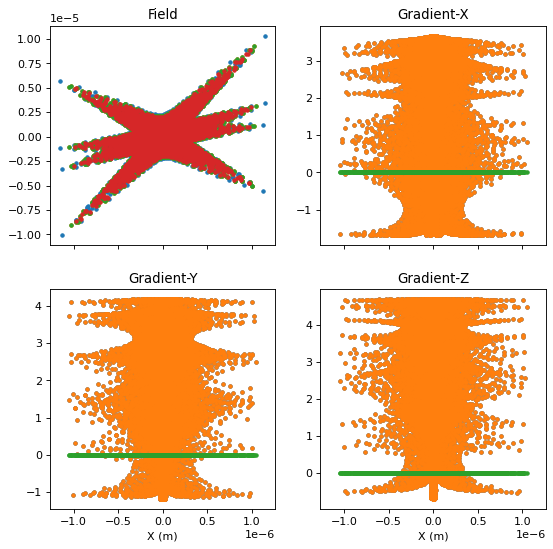

Done


In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

def test():
    #mesh=import_mesh('sphere_s61.hdf5')
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']

    unod=nodes[:,0]*2+nodes[:,1]*3+nodes[:,2]*4
    u2d_local=grad2d(nodes,faces,unod,dist_factor=1.0,local=True)
    u2d_global=grad2d(nodes,faces,unod,dist_factor=1.0,local=False)
    u2d_tangent=compute_tangent(nodes,faces,np.array([[0,2.0,3.0,4.0]]*len(faces)))
    u3d=grad3d(nodes,elements,unod,dist_factor=1.0)

    mids2d=compute_mids2d(nodes,faces,dist_factor=1.0)
    mids3d=compute_mids3d(nodes,elements,dist_factor=1.0)

    fig,ax=plt.subplots(2,2,sharex=True,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    axs[0].plot(nodes[:,0],unod,'.')
    axs[0].plot(mids2d[:,0],np.real(u2d_local[:,0]),'.')
    axs[0].plot(mids2d[:,0],np.real(u2d_global[:,0]),'.')
    axs[0].plot(mids3d[:,0],np.real(u3d[:,0]),'.')
    axs[0].set_title('Field')

    axs[1].plot(mids2d[:,0],np.real(u2d_global[:,1]),'.')
    axs[1].plot(mids2d[:,0],np.real(u2d_tangent[:,1]),'.')
    axs[1].plot(mids2d[:,0],np.real(u2d_global[:,1]-u2d_tangent[:,1]),'.')
    axs[1].set_title('Gradient-X')

    axs[2].plot(mids2d[:,0],np.real(u2d_global[:,2]),'.')
    axs[2].plot(mids2d[:,0],np.real(u2d_tangent[:,2]),'.')
    axs[2].plot(mids2d[:,0],np.real(u2d_global[:,2]-u2d_tangent[:,2]),'.')
    axs[2].set_title('Gradient-Y')

    axs[3].plot(mids2d[:,0],np.real(u2d_global[:,3]),'.')
    axs[3].plot(mids2d[:,0],np.real(u2d_tangent[:,3]),'.')
    axs[3].plot(mids2d[:,0],np.real(u2d_global[:,3]-u2d_tangent[:,3]),'.')
    axs[3].set_title('Gradient-Z')

    axs[2].set_xlabel('X (m)')
    axs[3].set_xlabel('X (m)')
    plt.show()
    return

if __name__=='__main__':
    test()
    print('Done')

# Sphere Mesh

## Diffuse layer

In [7]:
import numpy as np

def set_mesh():
    #modify user inputs below
    mesh_prefix='sphere'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=(1,2,3))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=5,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3,4),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=5,dtype='int')

    print('Reading %s.1.face'%mesh_prefix)
    faces=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=(1,2,3),dtype='int')
    face_flags=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=4,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    faces=faces-1

    # #translate z coordinate
    # print('Translating Z coordinate')
    # nodes[:,2]=-(np.power(10,-nodes[:,2]/1000*3)-1) #problem dependent
    #adjust mesh by radius
    print('Adjusting mesh by radius (will be removed in the future)')
    dist1=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
    mask=dist1>5.0
    dist2=np.zeros_like(dist1)
    dist2[mask]=10**((dist1[mask]-5)/50*2)+5-1

    # print(min(dist1[mask]),max(dist1[mask]))
    # print(min(dist2[mask]),max(dist2[mask]))
    nodes[mask,0]=nodes[mask,0]/dist1[mask]*dist2[mask]
    nodes[mask,1]=nodes[mask,1]/dist1[mask]*dist2[mask]
    nodes[mask,2]=nodes[mask,2]/dist1[mask]*dist2[mask]
    #scale nodes from meter to nano-meter
    nodes=nodes*1e-9

    nnode=len(nodes)
    nelem=len(elements)
    nface=len(faces)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF FACES IS: %d'%nface)
    print('')

    #define computational volume and boundaries
    in_active_zones=(zones==3)|(zones==4) #True for elements used in computation
    with_first_kind_bc=node_flags==40 #True for nodes on first kind b.c.
    with_third_kind_bc=face_flags==20 #True for faces on third kind b.c.

    #define electrolyte,solid,stern layer
    in_electrolyte=(zones==3)|(zones==4)
    in_solid=zones<=2
    in_stern=face_flags==20

    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=78.5 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    diffusion_electrolyte=2*1e-6**2/1e-3 #diffusion coefficient of water at 20 deg. C is 2*(1e-6*m)^2/(1e-3*s)
    diffusion_stern=2*1e-6**2/1e-2 #diffusion coefficient in Stern layer [m^2/s]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-9 #mobility in Stern layer [m^2/(Vs)]
    sigma_electrolyte=-0.01 #surface charge density in electrolyte [C/m^2]
    sigma_stern=-0.01 #surface charge density in Stern layer [C/m^2]

    temp_K=298 #room/ambient temperature [K]
    cinf=100 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',sigma_electrolyte)
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',sigma_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_electrolyte':sigma_electrolyte,'sigma_stern':sigma_stern,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}
    
    return physics

if __name__=='__main__':
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

Reading sphere.1.node
Reading sphere.1.ele
Reading sphere.1.face
Adjusting mesh by radius (will be removed in the future)
THE NUMBER OF NODES IS: 27548
THE NUMBER OF ELEMENTS IS: 157054
THE NUMBER OF FACES IS: 23928

THE NUMBER OF ACTIVE NODES IS: 15172
THE NUMBER OF ACTIVE ELEMENTS IS: 82685
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 3107
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2142

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.62e-10 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+09

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1

Done


## Entire domain

In [2]:
import numpy as np

def set_mesh():
    #modify user inputs below
    mesh_prefix='sphere'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=(1,2,3))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=5,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3,4),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=5,dtype='int')

    print('Reading %s.1.face'%mesh_prefix)
    faces=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=(1,2,3),dtype='int')
    face_flags=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=4,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    faces=faces-1

    # #translate z coordinate
    # print('Translating Z coordinate')
    # nodes[:,2]=-(np.power(10,-nodes[:,2]/1000*3)-1) #problem dependent
    #adjust mesh by radius
    print('Adjusting mesh by radius (will be removed in the future)')
    dist1=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
    mask=dist1>5.0
    dist2=np.zeros_like(dist1)
    dist2[mask]=10**((dist1[mask]-5)/50*2)+5-1

    # print(min(dist1[mask]),max(dist1[mask]))
    # print(min(dist2[mask]),max(dist2[mask]))
    nodes[mask,0]=nodes[mask,0]/dist1[mask]*dist2[mask]
    nodes[mask,1]=nodes[mask,1]/dist1[mask]*dist2[mask]
    nodes[mask,2]=nodes[mask,2]/dist1[mask]*dist2[mask]
    #scale nodes from meter to nano-meter
    nodes=nodes*1e-9

    nnode=len(nodes)
    nelem=len(elements)
    nface=len(faces)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF FACES IS: %d'%nface)
    print('')

    #define computational volume and boundaries
    in_active_zones=zones<=4 #True for elements used in computation
    with_first_kind_bc=node_flags==40 #True for nodes on first kind b.c.
    with_third_kind_bc=face_flags==20 #True for faces on third kind b.c.

    #define electrolyte,solid,stern layer
    in_electrolyte=(zones==3)|(zones==4)
    in_solid=zones<=2
    in_stern=face_flags==20
    on_outer_faces=face_flags==40

    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern,
          'on_outer_faces':on_outer_faces}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=78.5 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    diffusion_electrolyte=2*1e-6**2/1e-3 #diffusion coefficient of water at 20 deg. C is 2*(1e-6*m)^2/(1e-3*s)
    diffusion_stern=2*1e-6**2/1e-2 #diffusion coefficient in Stern layer [m^2/s]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-9 #mobility in Stern layer [m^2/(Vs)]
    sigma_electrolyte=-0.01 #surface charge density in electrolyte [C/m^2]
    sigma_stern=-0.01 #surface charge density in Stern layer [C/m^2]

    temp_K=298 #room/ambient temperature [K]
    cinf=100 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',sigma_electrolyte)
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',sigma_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_electrolyte':sigma_electrolyte,'sigma_stern':sigma_stern,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}
    
    return physics

if __name__=='__main__':
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

Reading sphere.1.node
Reading sphere.1.ele
Reading sphere.1.face
Adjusting mesh by radius (will be removed in the future)
THE NUMBER OF NODES IS: 27548
THE NUMBER OF ELEMENTS IS: 157054
THE NUMBER OF FACES IS: 23928

THE NUMBER OF ACTIVE NODES IS: 16663
THE NUMBER OF ACTIVE ELEMENTS IS: 95313
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 3107
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 2142

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.62e-10 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+09

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: -0.01
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -0.01
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1

Done


# Slab Mesh

# Decoupled Scalar Problem

In [ ]:
#dist_factor=1e9 passed test

## DSP template

In [8]:
def set_materials2d(mesh,physics,u2d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    c=np.zeros(nface,dtype=complex)
    alpha_x=np.zeros(nface,dtype=complex)
    alpha_y=np.zeros(nface,dtype=complex)
    alpha_z=np.zeros(nface,dtype=complex)

    beta_x=np.zeros(nface,dtype=complex)
    beta_y=np.zeros(nface,dtype=complex)
    beta_z=np.zeros(nface,dtype=complex)

    gamma_x=np.zeros(nface,dtype=complex)
    gamma_y=np.zeros(nface,dtype=complex)
    gamma_z=np.zeros(nface,dtype=complex)

    a=np.zeros(nface,dtype=complex)
    f=np.zeros(nface,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=0 #placeholder; not implemented yet
    anod=0 #placeholder; not implemented yet
    fnod=0 #placeholder; not implemented yet

    c[in_stern]=physics['diffusion_stern']
    gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_y[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_z[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    a[in_stern]=1j*freq

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials
    
def set_materials3d(mesh,physics,u3d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']

    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nface,dtype=complex)
    qs=np.zeros(nface,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    anod=np.zeros(nnode,dtype=complex)
    fnod=np.zeros(nnode,dtype=complex)

    c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']
    c[in_solid]=perm0*physics['rel_perm_solid']
    gs[in_stern]=-physics['sigma_electrolyte']

    ze=zval*echarge #ion valence times elementary charge
    u3d_scale=ze*u3d[:,0]/kB/temp_K #scaled potential in elements
    a[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u3d_scale)
    f[:]=-2*ze*kA*cinf*(np.sinh(u3d_scale)-np.cosh(u3d_scale)*u3d_scale)
    a[in_solid]=0
    f[in_solid]=0

    elements=mesh['elements']
    unod_scale=np.zeros(nnode)
    #anod[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(unod_scale)
    #fnod[:]=-2*ze*kA*cinf*(np.sinh(unod_scale)-np.cosh(unod_scale)*unod_scale)
    nind_solid=np.unique(elements[in_solid].flatten(order='C'))
    #anod[nind_solid]=0
    #fnod[nind_solid]=0

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials

def build_system(mesh,materials2d,materials3d,case):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*2,nnode*2))
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ks3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(nnode,nnode),nrep=1)
    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode,nnode),nrep=1)

    return K,b

if __name__=='__main__':
    #user input
    #meshfile='sphere_s61_electrolyte.hdf5'
    #physfile='sphere_s61_electrolyte.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9

    #setup mesh and material properties
    #mesh=import_mesh(meshfile)
    #physics=import_physics(physfile)
    u2d=np.zeros((len(mesh['faces']),4))
    u3d=np.zeros((len(mesh['elements']),4))
    materials2d=set_materials2d(mesh,physics,u2d,freq=0.1,case=1)
    materials3d=set_materials3d(mesh,physics,u3d,freq=0.1,case=1)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=1)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']

    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))

    unod=solve_unod(K/perm0,b/perm0)
    unod=reshape_unod(unod,nrep=1)
    output=output_unod(nodes,unod[:,0],srvfile)

    np.save('sphere_s61',unod)
    print('Done')

TEST CASE IS: 1
Setting material properties in Stern layer

TEST CASE IS: 1
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+09

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+09

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+09

Assembling the system of equations
Time elapsed  17.65322518348694 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.2056741714477539 sec

Assembling the system of equations
Time elapsed  0.4777696132659912 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  8.576610326766968 sec

Setting the unkonwns on inactive nodes as zeros
Time elapsed  0.10948681831359863 sec

Setting the unkonwns on inactive nodes as zeros
Time elapsed  0.08408784866333008 sec

Calling sparse linear system solver
Time elapsed  3.515167474746704 sec

Saving results to sphere_complex.srv.out

Done


## DSP plotting

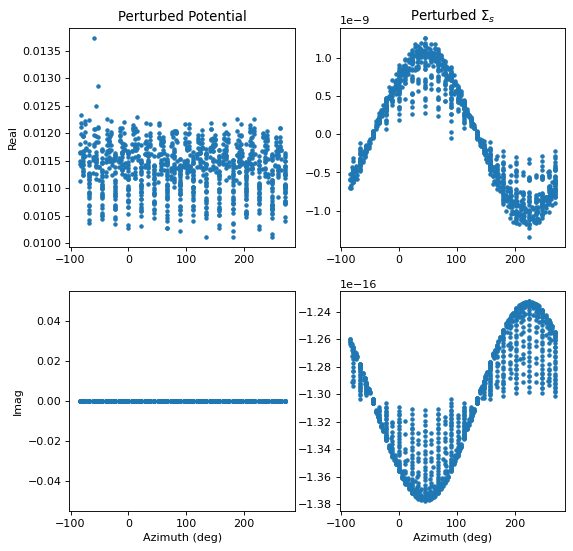

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Saving results to sphere_complex.srv.out



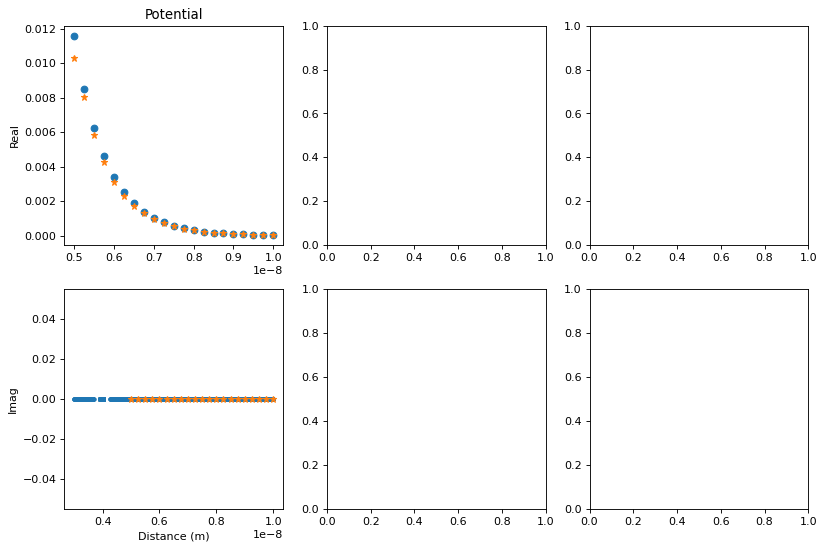

Computing fields and gradients in elements
Time elapsed  5.465873956680298 sec

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm



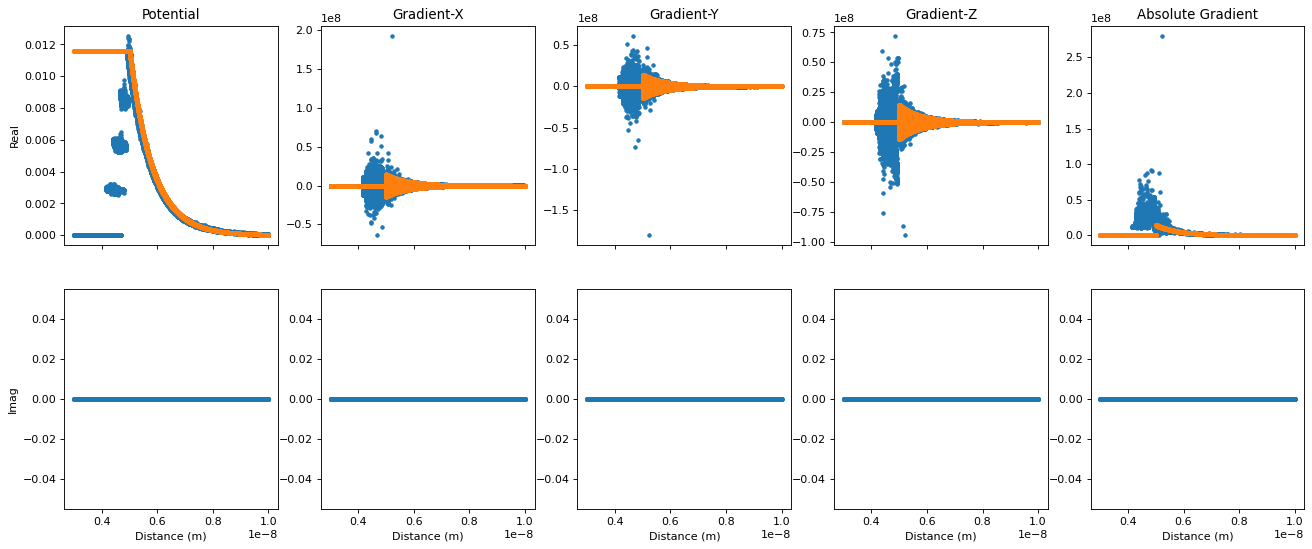

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    #first figure
    rho,theta,phi=cartesian2spherical(nodes[:,0],nodes[:,1],nodes[:,2])
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,0]),'.')
    axs[1].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,1]),'.')
    axs[2].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,0]),'.')
    axs[3].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,1]),'.')
    axs[0].set_title('Perturbed Potential')
    axs[1].set_title('Perturbed $\Sigma_s$')
    axs[2].set_xlabel('Azimuth (deg)')
    axs[3].set_xlabel('Azimuth (deg)')
    axs[0].set_ylabel('Real')
    axs[2].set_ylabel('Imag')
    plt.show()

    #second figure
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
    titles=['Potential']
    axs=ax.flatten()
    for i in range(1):
        output=output_unod(nodes,unod[:,i],srvfile)
        axs[i].plot(output[:,1],ansol[:,0],'o')
        axs[i].plot(output[:,1],output[:,6],'*')
        axs[i].set_title(titles[i])

        axs[i+3].plot(dist[mask],np.imag(unod[mask,i]),'.')
        axs[i+3].plot(output[:,1],output[:,7],'*')
        axs[i+3].set_xlabel('Distance (m)')
    axs[0].set_ylabel('Real')
    axs[3].set_ylabel('Imag')
    plt.show()

    #third figure
    mids=compute_mids3d(nodes,elements,dist_factor=1.0)
    dist=np.sqrt(mids[:,0]**2+mids[:,1]**2+mids[:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    u3d=grad3d(nodes,elements,unod[:,0],dist_factor=1.0)
    u3d=np.append(u3d,np.asmatrix(np.sqrt(u3d[:,1]**2+u3d[:,2]**2+u3d[:,3]**2)).T,axis=1)
    ansol=ansol_sphere(mids,a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    ansol=np.append(ansol,np.asmatrix(np.sqrt(ansol[:,1]**2+ansol[:,2]**2+ansol[:,3]**2)).T,axis=1)
    titles=['Potential','Gradient-X','Gradient-Y','Gradient-Z','Absolute Gradient']
    fig,ax=plt.subplots(2,5,sharex=True,figsize=(20,8),dpi=80)
    axs=ax.flatten()
    for i in range(u3d.shape[1]):
        axs[i].plot(dist[mask],np.real(u3d[mask,i]),'.')
        axs[i].plot(dist[mask],ansol[mask,i],'.')
        axs[i].set_title(titles[i])

        axs[i+5].plot(dist[mask],np.imag(u3d[mask,i]),'.')
        axs[i+5].set_xlabel('Distance (m)')

    axs[0].set_ylabel('Real')
    axs[5].set_ylabel('Imag')
    plt.show()

# Decoupled Vector Problem

In [ ]:
#dist_factor=1e9 passed test

## DVP template

In [4]:
def set_materials2d(mesh,physics,u2d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    c=np.zeros((nface,3,3),dtype=complex)
    alpha_x=np.zeros((nface,3,3),dtype=complex)
    alpha_y=np.zeros((nface,3,3),dtype=complex)
    alpha_z=np.zeros((nface,3,3),dtype=complex)

    beta_x=np.zeros((nface,3,3),dtype=complex)
    beta_y=np.zeros((nface,3,3),dtype=complex)
    beta_z=np.zeros((nface,3,3),dtype=complex)

    gamma_x=np.zeros((nface,3),dtype=complex)
    gamma_y=np.zeros((nface,3),dtype=complex)
    gamma_z=np.zeros((nface,3),dtype=complex)

    a=np.zeros((nface,3,3),dtype=complex)
    f=np.zeros((nface,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet
    anod=0j #placeholder;not implemented yet
    fnod=0j #placeholder; not implemented yet

    c[in_stern,2,2]=physics['diffusion_stern']
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_y[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_z[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']
    a[in_stern,0,0]=1j*freq
    a[in_stern,1,1]=1j*freq
    a[in_stern,2,2]=1j*freq

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials

def set_materials3d(mesh,physics,u3d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']

    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nface,3),dtype=complex)
    qs=np.zeros((nface,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)
    anod=np.zeros((nnode,3,3),dtype=complex)
    fnod=np.zeros((nnode,3),dtype=complex)

    c[in_electrolyte,2,2]=perm0*physics['rel_perm_electrolyte']
    c[in_solid,2,2]=perm0*physics['rel_perm_solid']
    gs[in_stern,2]=-physics['sigma_electrolyte']

    ze=zval*echarge #ion valence times elementary charge
    u3d_scale=ze*u3d[in_electrolyte,0]/kB/temp_K #scaled potential in elements
    #a[in_electrolyte,2,2]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u3d_scale)
    #f[in_electrolyte,2]=-2*ze*kA*cinf*(np.sinh(u3d_scale)-np.cosh(u3d_scale)*u3d_scale)
    #a[:,0,0]=1
    #a[:,1,1]=1
    
    elements=mesh['elements']
    unod_scale=np.zeros(nnode)
    anod[:,2,2]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(unod_scale)
    fnod[:,2]=-2*ze*kA*cinf*(np.sinh(unod_scale)-np.cosh(unod_scale)*unod_scale)
    nind_solid=np.unique(elements[in_solid].flatten(order='C'))
    anod[nind_solid,2,2]=0.0
    fnod[nind_solid,2]=0.0
    anod[:,0,0]=1.0
    anod[:,1,1]=1.0
    fnod[:,0]=1.0
    fnod[:,1]=1.0
    
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod[with_first_kind_bc,0]=1.0
    snod[with_first_kind_bc,1]=1.0

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials

def build_system(mesh,materials2d,materials3d,case):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode*6,nnode*6))
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=assemble_Ks3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(nnode*3,nnode*3),nrep=3)
    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)

    return K,b

if __name__=='__main__':
    #user input
    #meshfile='sphere_s61.hdf5'
    #physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1e9

    #setup mesh and material properties
    #mesh=import_mesh(meshfile)
    #physics=import_physics(physfile)
    u2d=np.zeros((len(mesh['faces']),4))
    u3d=np.zeros((len(mesh['elements']),4))
    materials2d=set_materials2d(mesh,physics,u2d,freq=0.1,case=2)
    materials3d=set_materials3d(mesh,physics,u3d,freq=0.1,case=2)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=2)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    unod=solve_unod(K/perm0,b/perm0)
    unod=reshape_unod(unod,nrep=3)
    output=output_unod(nodes,unod[:,0],srvfile)

    np.save('sphere_s61',unod)
    print('Done')

KeyError: 'faces'

## DVP plotting

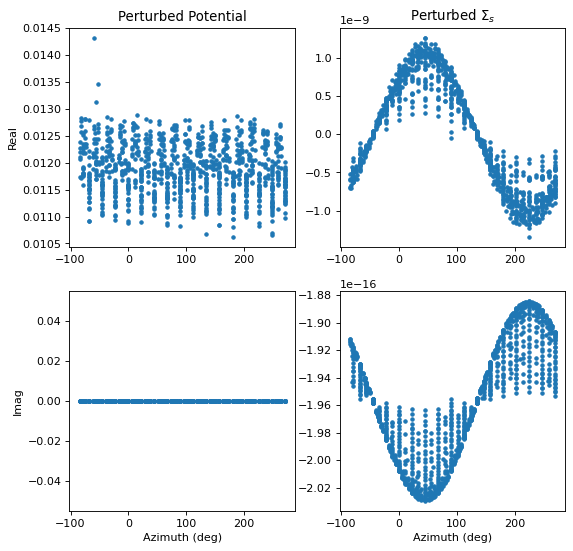

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out



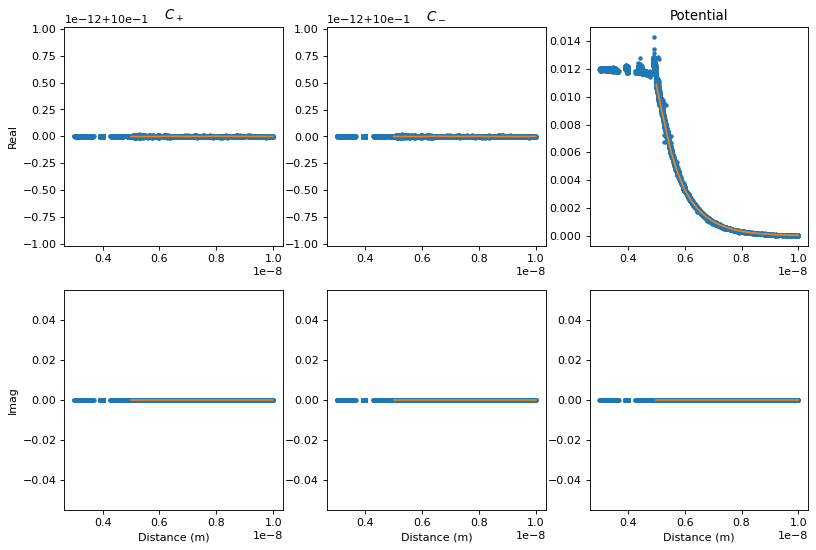

Saving results to sphere_complex.srv.out



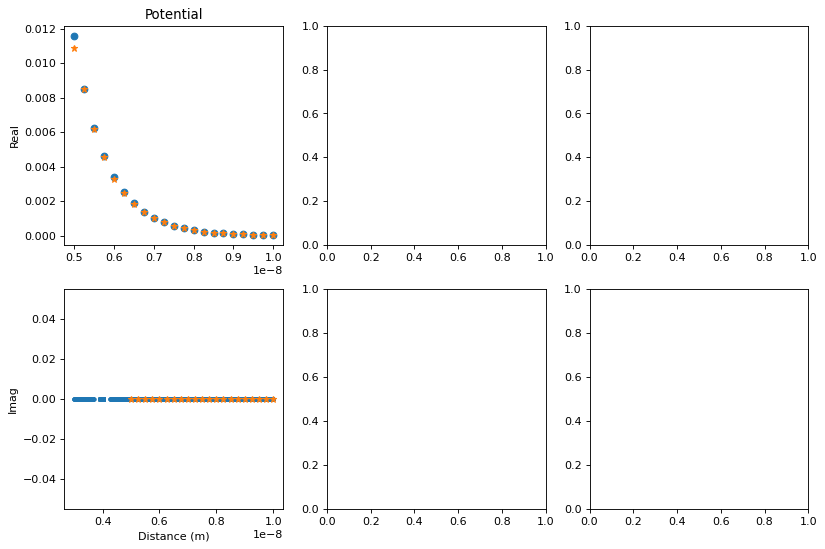

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    #first figure
    rho,theta,phi=cartesian2spherical(nodes[:,0],nodes[:,1],nodes[:,2])
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,2]),'.')
    axs[1].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,5]),'.')
    axs[2].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,2]),'.')
    axs[3].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,5]),'.')
    axs[0].set_title('Perturbed Potential')
    axs[1].set_title('Perturbed $\Sigma_s$')
    axs[2].set_xlabel('Azimuth (deg)')
    axs[3].set_xlabel('Azimuth (deg)')
    axs[0].set_ylabel('Real')
    axs[2].set_ylabel('Imag')
    plt.show()

    #second figure
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
    titles=['$C_+$','$C_-$','Potential']
    axs=ax.flatten()
    for i in range(3):
        output=output_unod(nodes,unod[:,i],srvfile)
        axs[i].plot(dist[mask],np.real(unod[mask,i]),'.')
        axs[i].plot(output[:,1],output[:,6])
        axs[i].set_title(titles[i])

        axs[i+3].plot(dist[mask],np.imag(unod[mask,i]),'.')
        axs[i+3].plot(output[:,1],output[:,7])
        axs[i+3].set_xlabel('Distance (m)')
    axs[0].set_ylabel('Real')
    axs[3].set_ylabel('Imag')
    plt.show()
    
    #third figure
    fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
    titles=['Potential']
    axs=ax.flatten()
    for i in range(1):
        output=output_unod(nodes,unod[:,i+2],srvfile)
        axs[i].plot(output[:,1],ansol[:,0],'o')
        axs[i].plot(output[:,1],output[:,6],'*')
        axs[i].set_title(titles[i])

        axs[i+3].plot(dist[mask],np.imag(unod[mask,i]),'.')
        axs[i+3].plot(output[:,1],output[:,7],'*')
        axs[i+3].set_xlabel('Distance (m)')
    axs[0].set_ylabel('Real')
    axs[3].set_ylabel('Imag')
    plt.show()


# Coupled Scalar Problem

Computing analytical solution
1.0 -1.0
zeta 0.0013841975799375498
cond_a 96.47243999999999
cond_d 0.0026939801481490194
cond_s -0.02

kS 0.9999871121850903
tau_a 6.249919451156814e-09
reflection_d (-0.4999806682776356+1.0070815712105028e-13j)
kM 0.9461301710832123
tau_s 6.605856351504419e-08

ccond_a (96.47243999999999+6.9472499999999996e-09j)
ccond_d (0.002486669948937262+1.3133488152019287e-11j)
ccond_s (8.727467627338446e-15+1.3609962703003075e-08j)

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out

(24157,) (24157, 6)


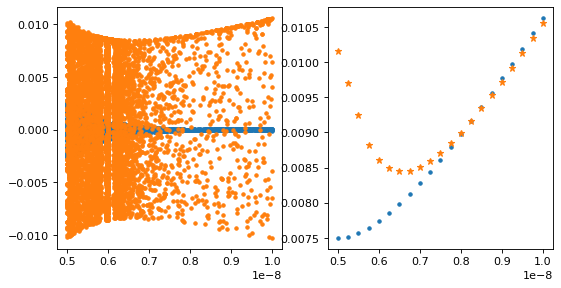

In [103]:
a=5e-9
e0=-1e6
freq=10

def ansol_dipole(mesh,physics):
    print('Computing analytical solution')
    nodes=mesh['nodes']
    rho,theta,phi=cartesian2spherical(nodes[:,0],nodes[:,1],nodes[:,2])
    print(np.max(np.cos(theta)),np.min(np.cos(theta)))
    
    perm_electrolyte=perm0*physics['rel_perm_electrolyte']
    perm_solid=perm0*physics['rel_perm_solid']
    diffusion_electrolyte=physics['diffusion_electrolyte']
    diffusion_stern=physics['diffusion_stern']
    mobility_electrolyte=physics['mobility_electrolyte']
    mobility_stern=physics['mobility_stern']
    sigma_electrolyte=physics['sigma_electrolyte']
    sigma_stern=physics['sigma_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    ze=zval*echarge
    debye_len=np.sqrt(perm_electrolyte*kB*temp_K/2/ze**2/kA/cinf)
    
    zeta=-2*kB*temp_K/ze*np.arcsinh(sigma_electrolyte/4/ze/kA/cinf/debye_len)
    sigma_d_plus=2*ze*kA*cinf*debye_len*(np.exp(-ze*zeta/2/kB/temp_K)-1)
    sigma_d_minus=-2*ze*kA*cinf*debye_len*(np.exp(ze*zeta/2/kB/temp_K)-1)
    cond_d_plus=2*mobility_electrolyte*sigma_d_plus/a
    cond_d_minus=-2*mobility_electrolyte*sigma_d_minus/a
    cond_a=2*mobility_electrolyte*ze*kA*cinf #check unit
    cond_d=cond_d_plus+cond_d_minus
    cond_s=2*mobility_stern*sigma_stern/a
#     print('sigma_d_plus',sigma_d_plus)
#     print('sigma_d_minus',sigma_d_minus)
#     print('sigma_d',sigma_electrolyte,sigma_d_plus+sigma_d_minus)
#     print('cond_d_plus',cond_d_plus)
#     print('cond_d_minus',cond_d_minus)
    print('zeta',zeta)
    print('cond_a',cond_a)
    print('cond_d',cond_d)
    print('cond_s',cond_s)    
    print('')

    cond_d=np.abs(cond_d)
    cond_s=np.abs(cond_s)
    
    dukhin=cond_d/2/cond_a
    kS=(dukhin+1)*cond_a**2/(cond_d_plus+cond_a)/(cond_d_minus+cond_a)
    tau_a=a**2*kS/2/diffusion_electrolyte
    reflection_d=(2*dukhin-1)/(2*dukhin+2)-1.5*kS*(cond_d_plus-cond_d_minus)**2/cond_a**2/\
                 (2*dukhin+2)**2*(1-1j*freq*tau_a/(1+np.sqrt(1j*freq*tau_a/kS)+1j*freq*tau_a))
    
    kM=1+sigma_stern/2/ze/kA/cinf/np.cosh(ze*zeta/2/kB/temp_K)/debye_len
    tau_s=a**2/2/diffusion_stern/kM
    print('kS',kS)
    print('tau_a',tau_a)
    print('reflection_d',reflection_d)
    print('kM',kM)
    print('tau_s',tau_s)
    print('')
    
    ccond_a=cond_a+1j*freq*perm_electrolyte
    ccond_d=ccond_a*(1+2*reflection_d)/(1-reflection_d)
    ccond_s=cond_s*1j*freq*tau_s/(1+1j*freq*tau_s)+1j*freq*perm_solid
    print('ccond_a',ccond_a)
    print('ccond_d',ccond_d)
    print('ccond_s',ccond_s)
    print('')
    
    ccond_c=ccond_d+ccond_s
    reflection_c=(ccond_c-ccond_a)/(2*ccond_a+ccond_c)
    
    unod=np.zeros(len(nodes),dtype=complex)    
    unod=e0*(-rho+reflection_c*a*a**2/rho**2)*nodes[:,0]/rho
    return unod

if __name__=='__main__':
#     mesh=import_mesh('sphere_s61.hdf5')
#     physics=import_physics('sphere_s61.hdf5')
    mask=((rho>5e-9)&(rho<1e-8))
    unod=ansol_dipole(mesh,physics)
    
    output=output_unod(mesh['nodes'],unod,'sphere_complex.srv')
    output2=output_unod(mesh['nodes'],unod2[:,2],'sphere_complex.srv')
    print(unod.shape,unod2.shape)
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    axs[0].plot(rho[mask],np.real(unod[mask]-unod2[mask,2]),'.')
    axs[0].plot(rho[mask],np.real(unod2[mask,2]),'.')
#     axs[1].plot(rho[mask],np.imag(unod[mask]),'.')
    axs[1].plot(output[:,1],np.real(output[:,6]),'.')
    axs[1].plot(output2[:,1],output2[:,6],'*')
    plt.show()

## CSP slab

In [19]:
def set_mesh():
    #modify user inputs below
    mesh_prefix='slab2'

    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=(1,2,3))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=1,usecols=5,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3,4),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=5,dtype='int')

    print('Reading %s.1.face'%mesh_prefix)
    faces=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=(1,2,3),dtype='int')
    face_flags=np.genfromtxt(mesh_prefix+'.1.face',skip_header=1,usecols=4,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    faces=faces-1

    #scale nodes from meter to nano-meter
    nodes=nodes*1e-9
    
    nnode=len(nodes)
    nelem=len(elements)
    nface=len(faces)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF FACES IS: %d'%nface)
    print('')

    #define computational volume and boundaries
    in_active_zones=zones>=0 #True for elements used in computation
    with_first_kind_bc=(node_flags==1)|(node_flags==2) #True for nodes on first kind b.c.
    with_third_kind_bc=face_flags==40 #True for faces on third kind b.c.

    #define electrolyte,solid,stern layer
    in_air=(zones<=2)|(zones==6)
    in_electrolyte=zones==3
    in_solid=(zones==4)|(zones==5)
    in_stern=face_flags==40

#     nind=node_flags==10
#     tmp1=np.sort(nodes[nind,:])
#     nind=np.unique(faces[face_flags==10,:].flatten(order='C'))
#     tmp2=np.sort(nodes[nind,:])
#     print('node_flags==10',len(tmp1))
#     print('face_flags==10',len(tmp2))
#     print(np.max(np.abs(tmp1-tmp2)))
    
    nind_e=np.unique(elements[in_active_zones,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_e))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',np.count_nonzero(with_first_kind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'faces':faces,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_air':in_air,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=80.0 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    diffusion_electrolyte=2*1e-6**2/1e-3 #diffusion coefficient of water at 20 deg. C is 2*(1e-6*m)^2/(1e-3*s)
    diffusion_stern=2*1e-6**2/1e-2 #diffusion coefficient in Stern layer [m^2/s]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-9 #mobility in Stern layer [m^2/(Vs)]
    sigma_electrolyte=0.0 #surface charge density in diffuse layer for steady state[C/m^2]
    sigma_stern=-100 #surface charge density in Stern layer for steady state[C/m^2]

    temp_K=273 #room/ambient temperature [K]
    cinf=1 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',sigma_electrolyte)
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',sigma_stern)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_electrolyte':sigma_electrolyte,'sigma_stern':sigma_stern,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}
    
    return physics

def set_materials2d(mesh,physics,u2d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros(nface,dtype=complex)
    alpha_x=np.zeros(nface,dtype=complex)
    alpha_y=np.zeros(nface,dtype=complex)
    alpha_z=np.zeros(nface,dtype=complex)

    beta_x=np.zeros(nface,dtype=complex)
    beta_y=np.zeros(nface,dtype=complex)
    beta_z=np.zeros(nface,dtype=complex)

    gamma_x=np.zeros(nface,dtype=complex)
    gamma_y=np.zeros(nface,dtype=complex)
    gamma_z=np.zeros(nface,dtype=complex)

    a=np.zeros(nface,dtype=complex)
    f=np.zeros(nface,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=0 #placeholder; not implemented yet
    anod=0 #placeholder; not implemented yet
    fnod=0 #placeholder; not implemented yet
    
    c[in_stern]=physics['diffusion_stern']
    gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_y[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_z[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    a[in_stern]=1j*freq
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials
    
def set_materials3d(mesh,physics,u3d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_air=mesh['in_air']
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
        
    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nface,dtype=complex)
    qs=np.zeros(nface,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    anod=np.zeros(nnode,dtype=complex)
    fnod=np.zeros(nnode,dtype=complex)
    
    c[in_air]=perm0
    c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']
    c[in_solid]=perm0*physics['rel_perm_solid']
    gs[in_stern]=1
        
    nodes=mesh['nodes']
    nind=np.argmin((nodes[:,0]-0.0)**2+(nodes[:,1]-0.0)**2+(nodes[:,2]-30.0e-9)**2)
    fnod[nind]=400*4*np.pi*perm0/20e-9*400/1.23e-09/5.77e+02*400
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def build_system(mesh,materials2d,materials3d,case):
    nnode=len(mesh['nodes'])
    mats3d_zero_gs=copy.deepcopy(materials3d)
    mats3d_zero_gs['gs'][:]=0

    mats2d_zero_gamma=copy.deepcopy(materials2d)
    mats2d_zero_gamma['gamma_x'][:]=0
    mats2d_zero_gamma['gamma_y'][:]=0
    mats2d_zero_gamma['gamma_z'][:]=0

    K=csr_matrix((nnode*2,nnode*2),dtype=complex)
    b=np.zeros(nnode*2,dtype=complex)
    K,b=assemble_Ke3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 element
    K,b=assemble_Ks3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=1) #K11 face
    K,b=assemble_Ke2d(mesh,mats2d_zero_gamma,K,b,offset=(nnode*1,nnode*1),nrep=1) #K22 element

    K,b=assemble_Ks3d2d(mesh,materials3d,K,b,offset=(0,nnode*1),nrep=1) #coupled term of K12
    K,b=assemble_Ke2d3d(mesh,materials2d,K,b,offset=(nnode*1,0),nrep=1) #coupled term of K12

    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=1) #K11 1st kind b.c.
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*1,nnode*1),nrep=1)
    
    return K,b

if __name__=='__main__':
    #user input
    mesh=set_mesh()
    physics=set_physics()
    dist_factor=1
    
    #setup mesh and material properties
    u2d=np.zeros((len(mesh['faces']),4))
    u3d=np.zeros((len(mesh['elements']),4))
    materials2d=set_materials2d(mesh,physics,u2d=u2d,freq=100.0,case=8)
    materials3d=set_materials3d(mesh,physics,u3d=u3d,freq=100.0,case=8)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=8)

    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    unod=solve_unod(K/perm0,b/perm0)
    unod=reshape_unod(unod,nrep=1)    
    np.save('slab2',unod)
    print('Done')

Reading slab2.1.node
Reading slab2.1.ele
Reading slab2.1.face
THE NUMBER OF NODES IS: 22404
THE NUMBER OF ELEMENTS IS: 141277
THE NUMBER OF FACES IS: 19632

THE NUMBER OF ACTIVE NODES IS: 22404
THE NUMBER OF ACTIVE ELEMENTS IS: 141277
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 124
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 6072

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.29e-09 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+08

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 80.0
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 2e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.9999999999999998e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: 0.0
SURFACE CHARGE DENSITY FOR STERN LAYER IS: -100
TEMPERATURE IS: 273
ION COCENTRATION AT INFINITY IS: 1
ION VALENCE IS: 1

TEST CASE IS: 8
Setting material properties in Stern layer

TEST CASE IS: 8
Setting material pro

In [20]:
unod100=copy.deepcopy(unod)

## CSP plotting

Saving results to slab_stern.srv.out

Saving results to slab_stern.srv.out



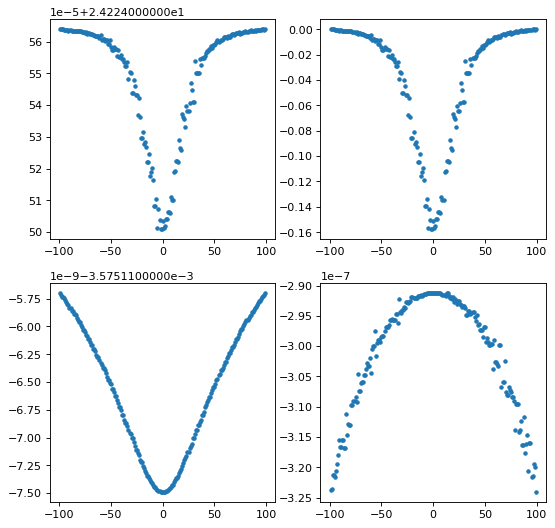

Saving results to slab_water.srv.out



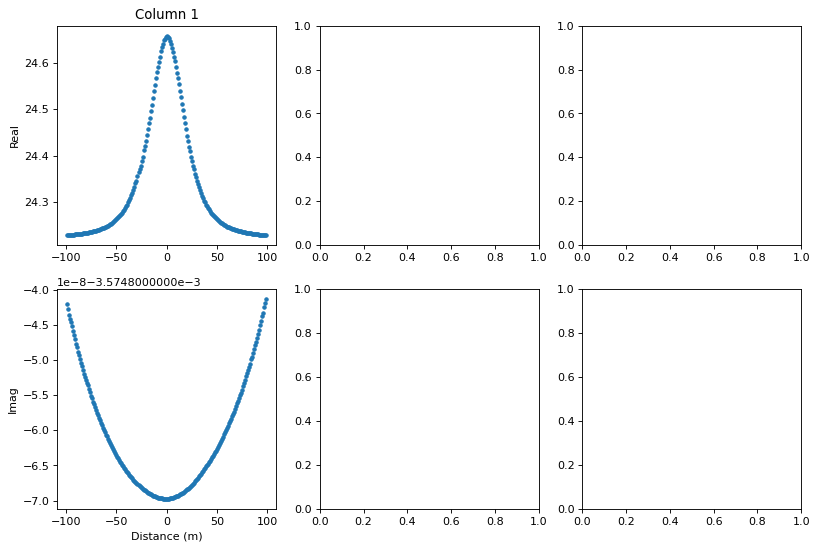

Saving results to slab_source.srv.out



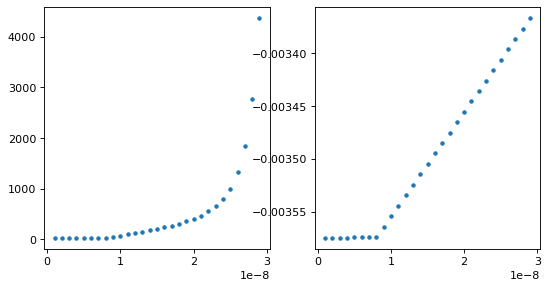

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    #first figure
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    output=output_unod(nodes[nind_stern,:],unod[nind_stern,0],'slab_stern.srv')
    mask=np.abs(output[:,1])<100e-9
    axs[0].plot(output[mask,1]*1e9,output[mask,6],'.')
    axs[2].plot(output[mask,1]*1e9,output[mask,7],'.')

    output=output_unod(nodes[nind_stern,:],unod[nind_stern,1],'slab_stern.srv')
    axs[1].plot(output[mask,1]*1e9,output[mask,6],'.')
    axs[3].plot(output[mask,1]*1e9,output[mask,7],'.')
    axs[0].set_title('Potential')
    axs[1].set_title('$\Sigma_s$')
    plt.show()

    #second figure
    fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
    axs=ax.flatten()
    for i in range(1):
        output=output_unod(nodes,unod[:,i],'slab_water.srv')
        mask=np.abs(output[:,1])<100e-9
        #axs[i].plot(nodes[:,0],np.real(unod[:,i]),'.')
        axs[i].plot(output[mask,1]*1e9,output[mask,6],'.')
        axs[i].set_title('Column %d'%(i+1))
        axs[i].set_ylabel('Real')
        #axs[i+3].plot(nodes[:,0],np.imag(unod[:,i]),'.')
        axs[i+3].plot(output[mask,1]*1e9,output[mask,7],'.')
        axs[i+3].set_xlabel('Distance (m)')
        axs[i+3].set_ylabel('Imag')
    plt.show()
    
    #third figure
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    output=output_unod(nodes,unod[:,0],'slab_source.srv')
    mask=output[:,3]<30e-9
    axs[0].plot(output[mask,3],output[mask,6],'.')
    axs[1].plot(output[mask,3],output[mask,7],'.')
    plt.show()

Saving results to slab_stern.srv.out

Saving results to slab_stern.srv.out



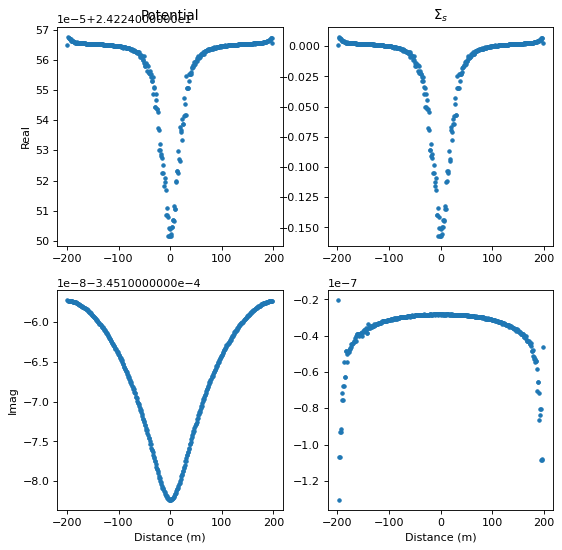

Saving results to slab_water.srv.out



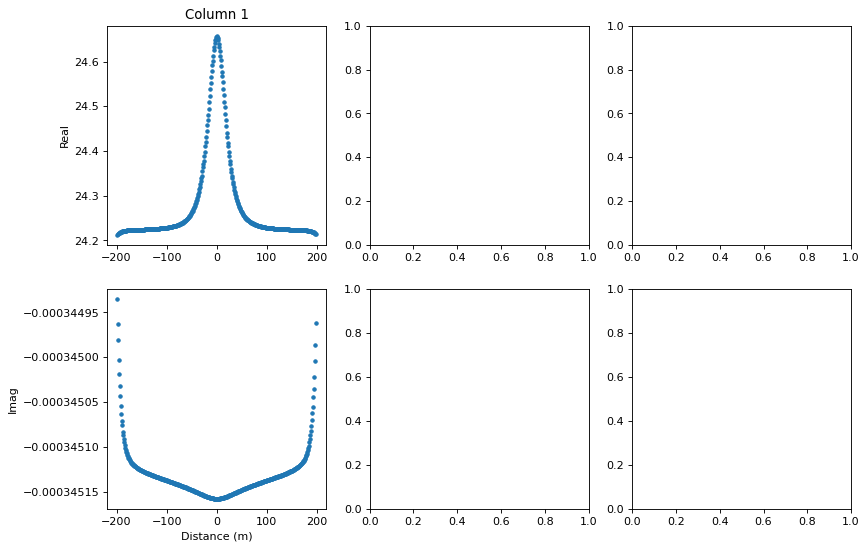

Saving results to slab_source.srv.out



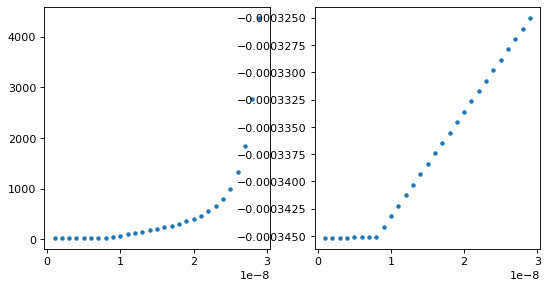

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

unod=unod100
if __name__=='__main__':
    #first figure
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    output=output_unod(nodes[nind_stern,:],unod[nind_stern,0],'slab_stern.srv')
    mask=np.abs(output[:,1])<500e-9
    axs[0].plot(output[mask,1]*1e9,output[mask,6],'.')
    axs[2].plot(output[mask,1]*1e9,output[mask,7],'.')

    output=output_unod(nodes[nind_stern,:],unod[nind_stern,1],'slab_stern.srv')
    axs[1].plot(output[mask,1]*1e9,output[mask,6],'.')
    axs[3].plot(output[mask,1]*1e9,output[mask,7],'.')
    axs[0].set_title('Potential')
    axs[1].set_title('$\Sigma_s$')
    axs[0].set_ylabel('Real')
    axs[2].set_ylabel('Imag')
    axs[2].set_xlabel('Distance (m)')
    axs[3].set_xlabel('Distance (m)')
    plt.show()

    #second figure
    fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
    axs=ax.flatten()
    for i in range(1):
        output=output_unod(nodes,unod[:,i],'slab_water.srv')
        mask=np.abs(output[:,1])<500e-9
        #axs[i].plot(nodes[:,0],np.real(unod[:,i]),'.')
        axs[i].plot(output[mask,1]*1e9,output[mask,6],'.')
        axs[i].set_title('Column %d'%(i+1))
        axs[i].set_ylabel('Real')
        #axs[i+3].plot(nodes[:,0],np.imag(unod[:,i]),'.')
        axs[i+3].plot(output[mask,1]*1e9,output[mask,7],'.')
        axs[i+3].set_xlabel('Distance (m)')
        axs[i+3].set_ylabel('Imag')
    plt.show()
    
    #third figure
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    output=output_unod(nodes,unod[:,0],'slab_source.srv')
    mask=output[:,3]<30e-9
    axs[0].plot(output[mask,3],output[mask,6],'.')
    axs[1].plot(output[mask,3],output[mask,7],'.')
    plt.show()

# Coupled Vector Problem

## CVP template

In [4]:
e0=1e2

def set_materials2d(mesh,physics,u2d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros((nface,3,3),dtype=complex)
    alpha_x=np.zeros((nface,3,3),dtype=complex)
    alpha_y=np.zeros((nface,3,3),dtype=complex)
    alpha_z=np.zeros((nface,3,3),dtype=complex)

    beta_x=np.zeros((nface,3,3),dtype=complex)
    beta_y=np.zeros((nface,3,3),dtype=complex)
    beta_z=np.zeros((nface,3,3),dtype=complex)

    gamma_x=np.zeros((nface,3),dtype=complex)
    gamma_y=np.zeros((nface,3),dtype=complex)
    gamma_z=np.zeros((nface,3),dtype=complex)

    a=np.zeros((nface,3,3),dtype=complex)
    f=np.zeros((nface,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet
    anod=0 #placeholder; not implemented yet
    fnod=0 #placeholder; not implemented yet

    c[in_stern,2,2]=physics['diffusion_stern']
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    gamma_y[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    gamma_z[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    a[in_stern,0,0]=1j*freq
    a[in_stern,1,1]=1j*freq
    a[in_stern,2,2]=1j*freq
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def set_materials3d(mesh,physics,u3d,freq,case):
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    
    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nface,3),dtype=complex)
    qs=np.zeros((nface,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)
    anod=np.zeros((nnode,3,3),dtype=complex)
    fnod=np.zeros((nnode,3),dtype=complex)
            
    c[in_electrolyte,0,0]=physics['diffusion_electrolyte']
    c[in_electrolyte,1,1]=physics['diffusion_electrolyte']
    c[in_electrolyte,2,2]=perm0*physics['rel_perm_electrolyte']

    c[in_electrolyte,0,2]=-physics['mobility_electrolyte']*cinf*np.exp(u3d[in_electrolyte,0]*echarge/kB/temp_K)
    c[in_electrolyte,1,2]=physics['mobility_electrolyte']*cinf*np.exp(-u3d[in_electrolyte,0]*echarge/kB/temp_K)

    c[in_solid,0,0]=0
    c[in_solid,1,1]=0
    c[in_solid,2,2]=perm0*physics['rel_perm_solid']

    alpha_x[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    alpha_z[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    alpha_x[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    alpha_z[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    a[:,0,0]=1j*freq
    a[:,1,1]=1j*freq

    a[in_electrolyte,2,0]=kA*echarge
    a[in_electrolyte,2,1]=-kA*echarge

    gs[in_stern,0]=0 #coupled coefficient; need to verify sign
    gs[in_stern,1]=0 #coupled coefficient; need to verify sign
    gs[in_stern,2]=1 #coupled coefficient; need to verify sign

    nodes=mesh['nodes']
    with_first_kind_bc=mesh['with_first_kind_bc']
    snod[with_first_kind_bc,2]=-nodes[with_first_kind_bc,0]*e0 #need to be updated
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def build_system(mesh,materials2d,materials3d,case):
    nnode=len(mesh['nodes'])
    mats3d_zero_gs=copy.deepcopy(materials3d)
    mats3d_zero_gs['gs'][:]=0

    mats2d_zero_gamma=copy.deepcopy(materials2d)
    mats2d_zero_gamma['gamma_x'][:]=0
    mats2d_zero_gamma['gamma_y'][:]=0
    mats2d_zero_gamma['gamma_z'][:]=0

    K=csr_matrix((nnode*6,nnode*6),dtype=complex)
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 element
    K,b=assemble_Ks3d(mesh,mats3d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 face
    K,b=assemble_Ke2d(mesh,mats2d_zero_gamma,K,b,offset=(nnode*3,nnode*3),nrep=3) #K22 element

    K,b=assemble_Ks3d2d(mesh,materials3d,K,b,offset=(0,nnode*3),nrep=3) #coupled term of K12
    K,b=assemble_Ke2d3d(mesh,materials2d,K,b,offset=(nnode*3,0),nrep=3) #coupled term of K12

    K,b=set_first_kind_bc3d(mesh,materials3d,K,b,offset=(0,0),nrep=3) #K11 1st kind b.c.
    K,b=set_inactive_nodes3d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)
    
    return K,b

if __name__=='__main__':
    #user input
    #meshfile='sphere_s61.hdf5'
    #physfile='sphere_s61.hdf5'
    srvfile='sphere_complex.srv'
    dist_factor=1
    
    #setup mesh and material properties
    #mesh=import_mesh(meshfile)
    #physics=import_physics(physfile)
    mids3d=compute_mids3d(mesh['nodes'],mesh['elements'],dist_factor)
    ansol=ansol_sphere(mids3d,a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    materials2d=set_materials2d(mesh,physics,u2d=0,freq=10,case=5)
    materials3d=set_materials3d(mesh,physics,u3d=ansol,freq=10,case=5)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    materials3d_scale=scale_materials(materials3d,dist_factor)
    K,b=build_system(mesh_scale,materials2d_scale,materials3d_scale,case=5)
    
    #initialize unknows
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_in=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(faces[in_stern,:].flatten(order='C'))
    
    unod=solve_unod(K,b)
    unod=reshape_unod(unod,nrep=3)
    output=output_unod(nodes,unod[:,0],srvfile)
    
    np.save('sphere_s61',unod)
    print('Done')

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

TEST CASE IS: 5
Setting material properties in Stern layer

TEST CASE IS: 5
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Assembling the system of equations
Time elapsed  115.20485615730286 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.7032160758972168 sec

Assembling the system of equations
Time elapsed  1.5383398532867432 sec

Implementing coupled terms of the system of equations (1/2)
Time elapsed  1.001889705657959 sec

Implementing coupled terms of the system of 

## CVP plotting

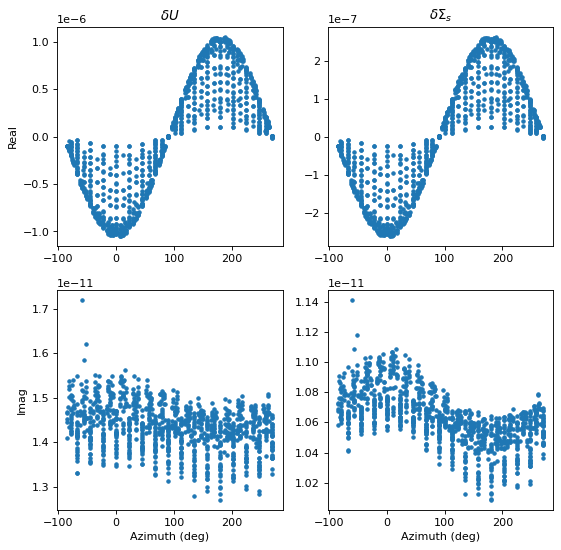

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out

Saving results to sphere_complex.srv.out



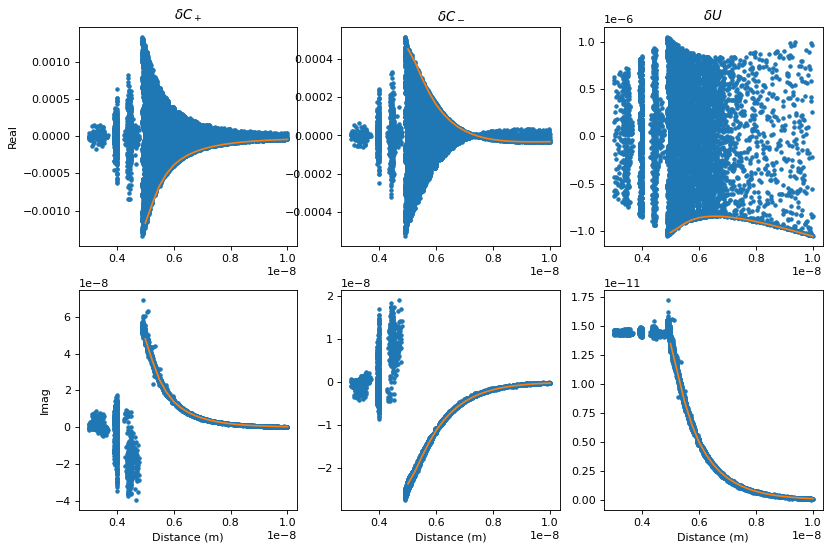

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    #first figure
    rho,theta,phi=cartesian2spherical(nodes[:,0],nodes[:,1],nodes[:,2])
    fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
    axs=ax.flatten()
    axs[0].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,2]),'.')
    axs[1].plot(phi[nind_stern]*180/np.pi,np.real(unod[nind_stern,5]),'.')
    axs[2].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,2]),'.')
    axs[3].plot(phi[nind_stern]*180/np.pi,np.imag(unod[nind_stern,5]),'.')
    axs[0].set_title('$\delta U$')
    axs[1].set_title('$\delta\Sigma_s$')
    axs[2].set_xlabel('Azimuth (deg)')
    axs[3].set_xlabel('Azimuth (deg)')
    axs[0].set_ylabel('Real')
    axs[2].set_ylabel('Imag')
    plt.show()

    #second figure
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2+nodes[:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    #ansol=ansol_sphere(output[:,1:5],a=5e-9,rel_perm=78.5,temp_K=298,
    #                   cinf=100,zval=1,zeta=0.01,gradflag=1)
    fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
    titles=['$\delta C_+$','$\delta C_-$','$\delta U$']
    axs=ax.flatten()
    for i in range(3):
        output=output_unod(nodes,unod[:,i],srvfile)
        axs[i].plot(dist[mask],np.real(unod[mask,i]),'.')
        axs[i].plot(output[:,1],output[:,6])
        axs[i].set_title(titles[i])

        axs[i+3].plot(dist[mask],np.imag(unod[mask,i]),'.')
        axs[i+3].plot(output[:,1],output[:,7])
        axs[i+3].set_xlabel('Distance (m)')
    axs[0].set_ylabel('Real')
    axs[3].set_ylabel('Imag')
    plt.show()

# Display results

## Dipole solution template

Solid Lines: M > 1; Dashed Lines: M = 1


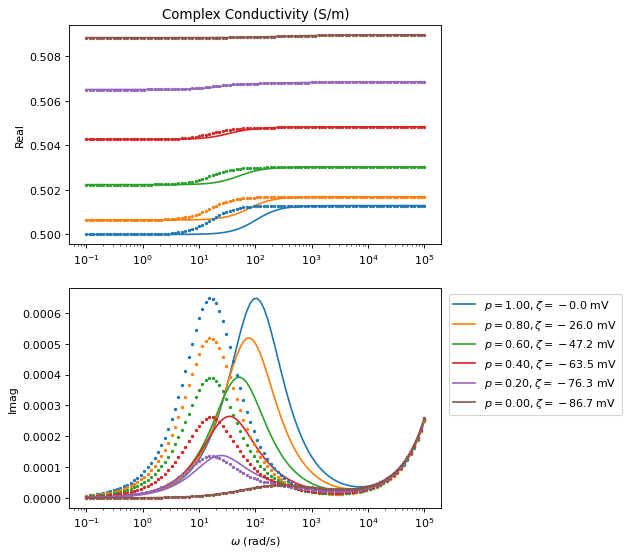

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
a=5e-6
e0=1e2
sigma_solid=-0.01
vol_frac=0.4
# vol_frac=1.0

def ansol_dipole(mesh,physics,freq,ratio,correction):
    nodes=mesh['nodes']
    rho,theta,phi=cartesian2spherical(nodes[:,0],nodes[:,1],nodes[:,2])
    
    perm_electrolyte=perm0*80.0
    perm_solid=perm0*4.5
    diffusion_electrolyte=2.0*1e-9
    diffusion_stern=0.2*1e-9
    mobility_electrolyte=1.0*5e-8
    mobility_stern=0.1*5e-8
    sigma_electrolyte=-(1-ratio)*sigma_solid
    sigma_stern=-ratio*sigma_solid
    
    temp_K=293.0
    cinf=1.0
    zval=1.0
    ze=zval*echarge
    debye_len=np.sqrt(perm_electrolyte*kB*temp_K/2/ze**2/kA/cinf)
    
    #in case of Stern layer polarization only (ratio = 1.0)
    #zeta,sigma_electrolyte,cond_d,ccond_d are zero
    #in case of diffuse layer polarization only (ratio = 0.0)
    #sigma_stern,cond_s,ccond_s-ccond_solid are zero
    zeta=-2*kB*temp_K/ze*np.arcsinh(sigma_electrolyte/4/ze/kA/cinf/debye_len) #eq 27
    sigma_d_plus=2*ze*kA*cinf*debye_len*(np.exp(-ze*zeta/2/kB/temp_K)-1) #eq 26
    sigma_d_minus=-2*ze*kA*cinf*debye_len*(np.exp(ze*zeta/2/kB/temp_K)-1) #eq 26
    cond_d_plus=2*mobility_electrolyte*sigma_d_plus/a #eq 25
    cond_d_minus=-2*mobility_electrolyte*sigma_d_minus/a #eq 25
    cond_a=2*mobility_electrolyte*ze*kA*cinf #guess
    #cond_a=kA*cinf*ze**2/kB/temp_K*diffusion_electrolyte
    cond_d=cond_d_plus+cond_d_minus #eq 24
    cond_s=2*mobility_stern*sigma_stern/a  #eq 28
#     print('sigma_d_plus',sigma_d_plus)
#     print('sigma_d_minus',sigma_d_minus)
#     print('sigma_d',sigma_electrolyte,sigma_d_plus+sigma_d_minus)
#     print('cond_d_plus',cond_d_plus)
#     print('cond_d_minus',cond_d_minus)
#     print('zeta',zeta)
#     print('cond_a',cond_a)
#     print('cond_d',cond_d)
#     print('cond_s',cond_s)    
#     print('')
    cond_d=np.abs(cond_d) #eq 24
    cond_s=np.abs(cond_s) #eq 28
    
    #Stern layer polarization only
    if correction:
        kM=1+sigma_stern/2/ze/kA/cinf/np.cosh(ze*zeta/2/kB/temp_K)/debye_len #eq 32
    else:
        kM=1
    tau_s=a**2/2/diffusion_stern/kM #eq 31
    ccond_s=cond_s*1j*freq*tau_s/(1+1j*freq*tau_s)+1j*freq*perm_solid #Stern layer polarization only
    
    #diffuse layer polarization only
    dukhin=cond_d/2/cond_a #Dukhin number
    kS=(dukhin+1)*cond_a**2/(cond_d_plus+cond_a)/(cond_d_minus+cond_a) #eq 34
    tau_a=a**2*kS/2/diffusion_electrolyte #time constant
    reflection_d=(2*dukhin-1)/(2*dukhin+2)-1.5*kS*(cond_d_plus-cond_d_minus)**2/cond_a**2/\
        (2*dukhin+2)**2*(1-1j*freq*tau_a/(1+np.sqrt(1j*freq*tau_a/kS)+1j*freq*tau_a)) #eq 33
    ccond_a=cond_a+1j*freq*perm_electrolyte #complex conductivity of electrolyte
    ccond_d=ccond_a*(1+2*reflection_d)/(1-reflection_d) #diffuse layer polarization only
#     print('ccond_s-ccond_solid',ccond_s-1j*freq*perm_solid)
#     print('ccond_d',ccond_d)
#     print('')
    
    ccond_c=ccond_d+ccond_s
    reflection_c=(ccond_c-ccond_a)/(2*ccond_a+ccond_c)
    unod=e0*(-rho+reflection_c*a*a**2/rho**2)*nodes[:,0]/rho
    
    ccond=(1+2*vol_frac*reflection_c)/(1-vol_frac*reflection_c) #eq 23
    return unod,ccond,zeta

if __name__=='__main__':
#     mesh=import_mesh('sphere_s61.hdf5')
#     physics=import_physics('sphere_s61.hdf5')
#     unod,cond,zeta=ansol_dipole(mesh,physics,freq=0.1,ratio=0.0)
    freqs=np.logspace(-1,5,100)
    ratios=np.arange(1.0,-0.2,-0.2)
    cond=np.zeros((len(ratios),len(freqs)),dtype=complex)
    zeta=np.zeros(len(ratios))
    for i in range(len(ratios)):
        for j in range(len(freqs)):
            ratio=ratios[i]
            freq=freqs[j]
            out1,out2,out3=ansol_dipole(mesh,physics,freq,ratio,correction=True)
            cond[i,j]=out2
            zeta[i]=out3

    print('Solid Lines: M > 1; Dashed Lines: M = 1')
    labels=[]
    fig,ax=plt.subplots(2,1,figsize=(6,8),dpi=80)
    axs=ax.flatten()
    for i in range(len(ratios)):
        axs[0].plot(freqs,np.real(cond[i,:]),'-')
        axs[1].plot(freqs,np.imag(cond[i,:]),'-')
        labels.append('$p=%.2f,\zeta=%.1f$ mV'%(ratios[i],zeta[i]*1e3))
    
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_ylabel('Real')
    axs[1].set_ylabel('Imag')
    axs[0].set_title('Complex Conductivity (S/m)')
    axs[1].set_xlabel('$\omega$ (rad/s)')
    axs[1].legend(labels,loc='upper right',bbox_to_anchor=(1.50,1.0))
    axs[0].axes.set_prop_cycle(None) #reset color cycle
    axs[1].axes.set_prop_cycle(None) #reset color cycle
    
    for i in range(len(ratios)):
        for j in range(len(freqs)):
            ratio=ratios[i]
            freq=freqs[j]
            out1,out2,out3=ansol_dipole(mesh,physics,freq,ratio,correction=False)
            cond[i,j]=out2
            zeta[i]=out3

    for i in range(len(ratios)):
        axs[0].plot(freqs,np.real(cond[i,:]),'.',markersize=4)
        axs[1].plot(freqs,np.imag(cond[i,:]),'.',markersize=4)
    
    plt.show()
    
#     print('Check simulated potential with analytical solution')
#     dist=np.sqrt(mesh['nodes'][:,0]**2+mesh['nodes'][:,1]**2+mesh['nodes'][:,2]**2)
#     mask=(dist>3e-9)&(dist<1e-8)
#     ansol,out2,out3=ansol_dipole(mesh,physics,freq=10.0,ratio=0.5,correction=True)
#     fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
#     axs=ax.flatten()
#     #axs[0].plot(dist[mask],np.real(unod[mask,2]),'.')
#     axs[0].plot(dist[mask],np.real(ansol[mask]),'.')
#     #axs[0].plot(dist[mask],np.real(unod[mask,2]-ansol[mask]),'.')
    
#     #axs[1].plot(dist[mask],np.imag(unod[mask,2]),'.')
#     axs[1].plot(dist[mask],np.imag(out1[mask]),'.')
#     #axs[1].plot(dist[mask],np.imag(unod[mask,2]-ansol[mask]),'.')
    
#     axs[0].set_xlabel('Distance (m)')
#     axs[1].set_xlabel('Distance (m)')
#     axs[0].set_title('Real $\delta U$')
#     axs[1].set_title('Imag $\delta U$')

## Dipole solution plotting

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
a=5e-9
e0=1e2
sigma_solid=0.02
vol_frac=1.0

def ansol_dipole(mesh,physics,freq,ratio,correction):
    nodes=mesh['nodes']
    rho,theta,phi=cartesian2spherical(nodes[:,0],nodes[:,1],nodes[:,2])
    
#     perm_electrolyte=perm0*80.0
#     perm_solid=perm0*4.5
#     diffusion_electrolyte=2.0*1e-9
#     diffusion_stern=0.2*1e-9
#     mobility_electrolyte=1.0*5e-8
#     mobility_stern=0.1*5e-8
#     sigma_electrolyte=-(1-ratio)*sigma_solid
#     sigma_stern=-ratio*sigma_solid
    
#     temp_K=293.0
#     cinf=1.0
#     zval=1.0
#     ze=zval*echarge
#     debye_len=np.sqrt(perm_electrolyte*kB*temp_K/2/ze**2/kA/cinf)
#     print('DEBYE LENGTH IS:',debye_len*1e9,'nm')
    
    perm_electrolyte=perm0*physics['rel_perm_electrolyte']
    perm_solid=perm0*physics['rel_perm_solid']
    diffusion_electrolyte=physics['diffusion_electrolyte']
    diffusion_stern=physics['diffusion_stern']
    mobility_electrolyte=physics['mobility_electrolyte']
    mobility_stern=physics['mobility_stern']
    sigma_electrolyte=-(1-ratio)*sigma_solid
    sigma_stern=-ratio*sigma_solid
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    ze=zval*echarge
    debye_len=np.sqrt(perm_electrolyte*kB*temp_K/2/ze**2/kA/cinf)
    
    #in case of Stern layer polarization only (ratio = 1.0)
    #zeta,sigma_electrolyte,cond_d,ccond_d are zero
    #in case of diffuse layer polarization only (ratio = 0.0)
    #sigma_stern,cond_s,ccond_s-ccond_solid are zero
    zeta=-2*kB*temp_K/ze*np.arcsinh(sigma_electrolyte/4/ze/kA/cinf/debye_len) #eq 27
    sigma_d_plus=2*ze*kA*cinf*debye_len*(np.exp(-ze*zeta/2/kB/temp_K)-1) #eq 26
    sigma_d_minus=-2*ze*kA*cinf*debye_len*(np.exp(ze*zeta/2/kB/temp_K)-1) #eq 26
    cond_d_plus=2*mobility_electrolyte*sigma_d_plus/a #eq 25
    cond_d_minus=-2*mobility_electrolyte*sigma_d_minus/a #eq 25
    cond_a=2*mobility_electrolyte*ze*kA*cinf #guess
    #cond_a=kA*cinf*ze**2/kB/temp_K*diffusion_electrolyte
    cond_d=cond_d_plus+cond_d_minus #eq 24
    cond_s=2*mobility_stern*sigma_stern/a  #eq 28
#     print('sigma_d_plus',sigma_d_plus)
#     print('sigma_d_minus',sigma_d_minus)
#     print('sigma_d',sigma_electrolyte,sigma_d_plus+sigma_d_minus)
#     print('cond_d_plus',cond_d_plus)
#     print('cond_d_minus',cond_d_minus)
#     print('zeta',zeta)
#     print('cond_a',cond_a)
#     print('cond_d',cond_d)
#     print('cond_s',cond_s)    
#     print('')
    cond_d=np.abs(cond_d) #eq 24
    cond_s=np.abs(cond_s) #eq 28
    
    #Stern layer polarization only
    if correction:
        kM=1+sigma_stern/2/ze/kA/cinf/np.cosh(ze*zeta/2/kB/temp_K)/debye_len #eq 32
    else:
        kM=1
    tau_s=a**2/2/diffusion_stern/kM #eq 31
    ccond_s=cond_s*1j*freq*tau_s/(1+1j*freq*tau_s)+1j*freq*perm_solid #Stern layer polarization only
    
    #diffuse layer polarization only
    dukhin=cond_d/2/cond_a #Dukhin number
    kS=(dukhin+1)*cond_a**2/(cond_d_plus+cond_a)/(cond_d_minus+cond_a) #eq 34
    tau_a=a**2*kS/2/diffusion_electrolyte #time constant
    reflection_d=(2*dukhin-1)/(2*dukhin+2)-1.5*kS*(cond_d_plus-cond_d_minus)**2/cond_a**2/\
        (2*dukhin+2)**2*(1-1j*freq*tau_a/(1+np.sqrt(1j*freq*tau_a/kS)+1j*freq*tau_a)) #eq 33
    ccond_a=cond_a+1j*freq*perm_electrolyte #complex conductivity of electrolyte
    ccond_d=ccond_a*(1+2*reflection_d)/(1-reflection_d) #diffuse layer polarization only
#     print('ccond_s-ccond_solid',ccond_s-1j*freq*perm_solid)
#     print('ccond_d',ccond_d)
#     print('')
    
    ccond_c=ccond_d+ccond_s
    reflection_c=(ccond_c-ccond_a)/(2*ccond_a+ccond_c)
    unod=e0*(-rho+reflection_c*a*a**2/rho**2)*nodes[:,0]/rho
    
    ccond=(1+2*vol_frac*reflection_c)/(1-vol_frac*reflection_c) #eq 23
    return unod,ccond*ccond_a,zeta

if __name__=='__main__':
#     mesh=import_mesh('sphere_s61.hdf5')
#     physics=import_physics('sphere_s61.hdf5')
    freqs=np.logspace(-1,5,100)
    #ratios=np.arange(1.0,-0.2,-0.2)
    ratios=np.arange(1.0,-0.05,-0.05)
    cond=np.zeros((len(ratios),len(freqs)),dtype=complex)
    zeta=np.zeros(len(ratios))
    for i in range(len(ratios)):
        for j in range(len(freqs)):
            ratio=ratios[i]
            freq=freqs[j]
            out1,out2,out3=ansol_dipole(mesh,physics,freq,ratio,correction=True)
            cond[i,j]=out2
            zeta[i]=out3
    
    print('Solid Lines: M > 1; Dashed Lines: M = 1')
    labels=[]
    fig,ax=plt.subplots(2,1,figsize=(6,8),dpi=80)
    axs=ax.flatten()
    for i in range(0,len(ratios),4):
        axs[0].plot(freqs,np.real(cond[i,:]),'-')
        axs[1].plot(freqs,np.imag(cond[i,:]),'-')
        labels.append('$p=%.2f,\zeta=%.1f$ mV'%(ratios[i],zeta[i]*1e3))
    
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_ylabel('Real')
    axs[1].set_ylabel('Imag')
    axs[0].set_title('Complex Conductivity (S/m)')
    axs[1].set_xlabel('$\omega$ (rad/s)')
    axs[1].legend(labels,loc='upper right',bbox_to_anchor=(1.50,1.0))
    axs[0].axes.set_prop_cycle(None) #reset color cycle
    axs[1].axes.set_prop_cycle(None) #reset color cycle
    
    for i in range(len(ratios)):
        for j in range(len(freqs)):
            ratio=ratios[i]
            freq=freqs[j]
            out1,out2,out3=ansol_dipole(mesh,physics,freq,ratio,correction=False)
            cond[i,j]=out2
            zeta[i]=out3

    for i in range(0,len(ratios),4):
        axs[0].plot(freqs,np.real(cond[i,:]),'.',markersize=4)
        axs[1].plot(freqs,np.imag(cond[i,:]),'.',markersize=4)
    
    plt.show()
    
    print('%10s %10s %10s'%('ratio','zeta','real_cond'))
    for i in [0,4,10,16,20]:
        print('%10.2f %10.6f %10.6f'%(ratios[i],zeta[i],np.real(cond[i,0])))
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    axs[0].plot(ratios,np.real(cond[:,0]),'.')
    axs[1].plot(ratios,np.imag(cond[:,0]),'.')
    
    axs[0].plot(ratios[::10],np.real(cond[::10,0]),'x')
    axs[1].plot(ratios[::10],np.imag(cond[::10,0]),'x')

    axs[0].set_xlabel('Ratio')
    axs[1].set_xlabel('Ratio')
    axs[0].set_title('Real $(\omega=0.1)$')
    axs[1].set_title('Imag $(\omega=0.1)$')
    plt.show()
    
    print('Check simulated potential with analytical solution')
    dist=np.sqrt(mesh['nodes'][:,0]**2+mesh['nodes'][:,1]**2+mesh['nodes'][:,2]**2)
    mask=(dist>3e-9)&(dist<1e-8)
    ansol,out2,out3=ansol_dipole(mesh,physics,freq=10.0,ratio=0.5,correction=True)
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    axs[0].plot(dist[mask],np.real(unod[mask,2]),'.')
    axs[0].plot(dist[mask],np.real(ansol[mask]),'.')
    axs[0].plot(dist[mask],np.real(unod[mask,2]-ansol[mask]),'.')
    
    axs[1].plot(dist[mask],np.imag(unod[mask,2]),'.')
    axs[1].plot(dist[mask],np.imag(out1[mask]),'.')
    axs[1].plot(dist[mask],np.imag(unod[mask,2]-ansol[mask]),'.')
    
    axs[0].set_xlabel('Distance (m)')
    axs[1].set_xlabel('Distance (m)')
    axs[0].set_title('Real $\delta U$')
    axs[1].set_title('Imag $\delta U$')

NameError: name 'mesh' is not defined

## Complex conductivity

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-09
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 78.5
TEMPERATURE IS: 298
ION COCENTRATION AT INFINITY IS: 100
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: 0.01
DEBYE LENGTH IS: 0.9617530004493543 nm

Computing fields and gradients in elements
Time elapsed  5.269969701766968 sec

Computing fields and gradients in elements
Time elapsed  5.2446558475494385 sec

Computing fields and gradients in elements
Time elapsed  5.264685392379761 sec

Computing fields and gradients on faces
Time elapsed  3.58518123626709 sec

Computing fields and gradients on faces
Time elapsed  3.576030731201172 sec

Computing fields and gradients on faces
Time elapsed  3.583606481552124 sec



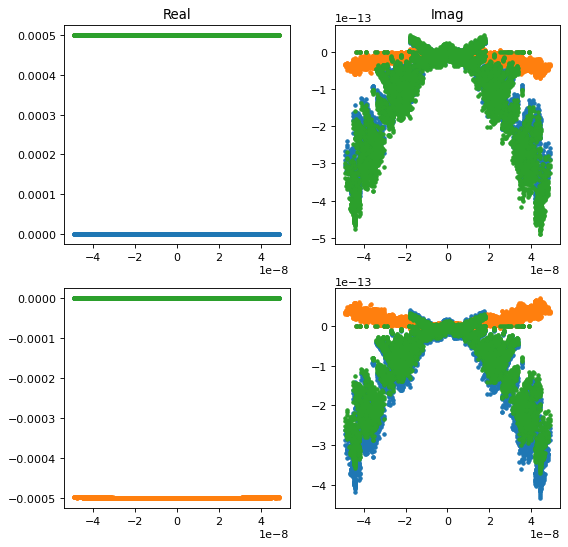

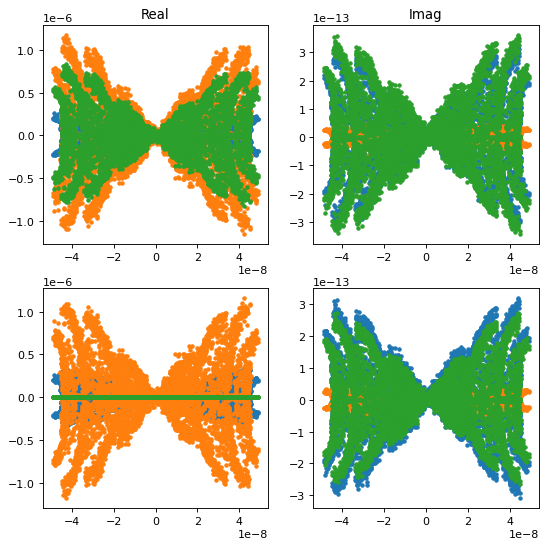

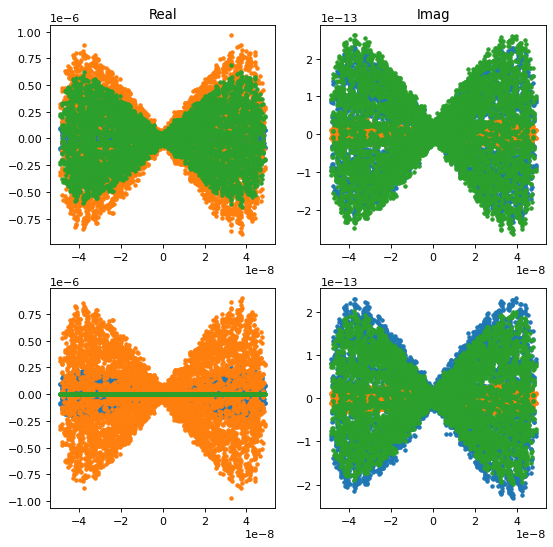

(-0.0003874170379348918+3.6612152624488195e-10j)
(0.0003890787611639322-3.665385504584036e-10j)
(8.909211523523027e-10-2.4413968393858476e-16j)


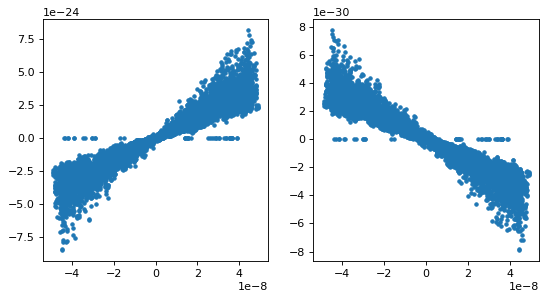

Done


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
e0=1e2

def find_eind(faces,elements,zones):
    eind=np.zeros((len(faces),2),dtype=int)-1
    for i in range(len(faces)):
        nind=faces[i,:]
        mask0=(((elements[:,0]==nind[0])|(elements[:,1]==nind[0]))|(elements[:,2]==nind[0]))|(elements[:,3]==nind[0])
        mask1=(((elements[:,0]==nind[1])|(elements[:,1]==nind[1]))|(elements[:,2]==nind[1]))|(elements[:,3]==nind[1])
        mask2=(((elements[:,0]==nind[2])|(elements[:,1]==nind[2]))|(elements[:,2]==nind[2]))|(elements[:,3]==nind[2])
        mask=((mask0&mask1)&(mask2))&zones
        if np.sum(mask)>0:
            eind[i,0]=np.where(mask)[0][0]
        if np.sum(mask)>1:
            eind[i,1]=np.where(mask)[0][1]
    return eind

def compute_cond():
    mids2d=compute_mids2d(mesh['nodes'],mesh['faces'],dist_factor=1.0)
    ansol=ansol_sphere(mids2d,a=5e-9,rel_perm=78.5,temp_K=298,
                       cinf=100,zval=1,zeta=0.01,gradflag=1)
    u3d=[grad3d(mesh['nodes'],mesh['elements'],unod[:,0],dist_factor=1.0)[eind[:,0],:],
         grad3d(mesh['nodes'],mesh['elements'],unod[:,1],dist_factor=1.0)[eind[:,0],:],
         grad3d(mesh['nodes'],mesh['elements'],unod[:,2],dist_factor=1.0)[eind[:,0],:]]
    u2d=[grad2d(mesh['nodes'],mesh['faces'],unod[:,0],dist_factor=1.0,local=False),
         grad2d(mesh['nodes'],mesh['faces'],unod[:,1],dist_factor=1.0,local=False),
         grad2d(mesh['nodes'],mesh['faces'],unod[:,2],dist_factor=1.0,local=False)]
    
    nodes=mesh['nodes']
    elements=mesh['elements']
    faces=mesh['faces']
    
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nface=len(mesh['faces'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    on_outer_faces=mesh['on_outer_faces']
    
    diffusion_electrolyte=physics['diffusion_electrolyte']
    mobility_electrolyte=physics['mobility_electrolyte']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    
    #print('cond_a 1):',2*mobility_electrolyte*echarge*kA*cinf)
    #print('cond_a 2):',kA*cinf*echarge**2/kB/temp_K*diffusion_electrolyte)
    
    flux_neg=np.zeros((len(faces),3),dtype=complex)
    flux_pos=np.zeros((len(faces),3),dtype=complex)

    for i in range(3): #gradient-x,-y,-z
        fig,ax=plt.subplots(2,2,figsize=(8,8),dpi=80)
        axs=ax.flatten()
        
        pa1=diffusion_electrolyte*u3d[0][:,i+1]
        pa2=-mobility_electrolyte*cinf*np.exp(ansol[:,0]*echarge/kB/temp_K)*u3d[2][:,i+1]
        pa3=-mobility_electrolyte*ansol[:,i+1]*u2d[0][:,0]
        flux_neg[:,i]=pa1+pa2+pa3
        axs[0].plot(mids2d[on_outer_faces,0],np.real(pa1[on_outer_faces]),'.')
        axs[0].plot(mids2d[on_outer_faces,0],np.real(pa2[on_outer_faces]),'.')
        #axs[0].plot(mids2d[on_outer_faces,0],np.real(pa3[on_outer_faces]),'.')
        axs[0].plot(mids2d[on_outer_faces,0],np.real(flux_neg[on_outer_faces,i]),'.')
        axs[1].plot(mids2d[on_outer_faces,0],np.imag(pa1[on_outer_faces]),'.')
        axs[1].plot(mids2d[on_outer_faces,0],np.imag(pa2[on_outer_faces]),'.')
        #axs[1].plot(mids2d[on_outer_faces,0],np.imag(pa3[on_outer_faces]),'.')
        axs[1].plot(mids2d[on_outer_faces,0],np.imag(flux_neg[on_outer_faces,i]),'.')
        axs[0].set_title('Real')
        axs[1].set_title('Imag')
        
        pb1=diffusion_electrolyte*u3d[1][:,i+1]
        pb2=mobility_electrolyte*cinf*np.exp(-ansol[:,0]*echarge/kB/temp_K)*u3d[2][:,i+1]
        pb3=mobility_electrolyte*ansol[:,i+1]*u2d[1][:,0]
        flux_pos[:,i]=pb1+pb2+pb3
        axs[2].plot(mids2d[on_outer_faces,0],np.real(pb1[on_outer_faces]),'.')
        axs[2].plot(mids2d[on_outer_faces,0],np.real(pb2[on_outer_faces]),'.')
        axs[2].plot(mids2d[on_outer_faces,0],np.real(pb3[on_outer_faces]),'.')
        #axs[2].plot(mids2d[on_outer_faces,0],np.real(flux_pos[on_outer_faces,i]),'.')
        axs[3].plot(mids2d[on_outer_faces,0],np.imag(pb1[on_outer_faces]),'.')
        axs[3].plot(mids2d[on_outer_faces,0],np.imag(pb2[on_outer_faces]),'.')
        #axs[3].plot(mids2d[on_outer_faces,0],np.imag(pb3[on_outer_faces]),'.')
        axs[3].plot(mids2d[on_outer_faces,0],np.imag(flux_pos[on_outer_faces,i]),'.')
        plt.show()
    
    flux=flux_pos+flux_neg
    cond=np.zeros(len(faces),dtype=complex)
    area=np.zeros(len(faces))
    for i in range(len(faces)):
        nind=faces[i,:]
        xnod=nodes[nind,0]
        ynod=nodes[nind,1]
        znod=nodes[nind,2]
        a=[xnod[1]-xnod[0],ynod[1]-ynod[0],znod[1]-znod[0]]
        b=[xnod[2]-xnod[1],ynod[2]-ynod[1],znod[2]-znod[1]]
        n=np.cross(a,b)
        area[i]=np.linalg.norm(n)/2
        n=n/np.linalg.norm(n)
        
        xr=sum(nodes[nind,0])/3
        yr=sum(nodes[nind,1])/3
        zr=sum(nodes[nind,2])/3
        r=np.array([xr,yr,zr])
        r=r/np.linalg.norm(r)
        if np.dot(n,r)<0:
            n=-n
        cond[i]=(flux[i,0]*n[0]+flux[i,1]*n[1]+flux[i,2]*n[2])*area[i]
    
    mask=on_outer_faces&(mids2d[:,0]<=0)
    print(np.sum(cond[mask])/np.sum(area[mask])*kA*echarge/e0)
    mask=on_outer_faces&(mids2d[:,0]>=0)
    print(np.sum(cond[mask])/np.sum(area[mask])*kA*echarge/e0)
    mask=on_outer_faces
    print(np.sum(cond[mask])/np.sum(area[mask]))
    
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    axs[0].plot(mids2d[on_outer_faces,0],np.real(cond[on_outer_faces]),'.')
    axs[1].plot(mids2d[on_outer_faces,0],np.imag(cond[on_outer_faces]),'.')
    plt.show()
    return

if __name__=='__main__':
    #eind=find_eind(mesh['faces'],mesh['elements'],mesh['in_active_zones'])
    eind=np.load('eind.npy')
    #unod=np.load('sphere_s61_ratio_0p5.npy')
    compute_cond()
    print('Done')

In [ ]:
(0.0003874170379381424-3.6612152634925353e-10j)
(-0.00038907876116083933+3.6653855033581864e-10j)
(-8.909211490645301e-06+2.4413956631022885e-12j)


In [5]:
tmp=grad3d(mesh['nodes'],mesh['elements'],unod[:,2],dist_factor=1.0)[eind[:,0],:]

Computing fields and gradients in elements
Time elapsed  5.4156177043914795 sec



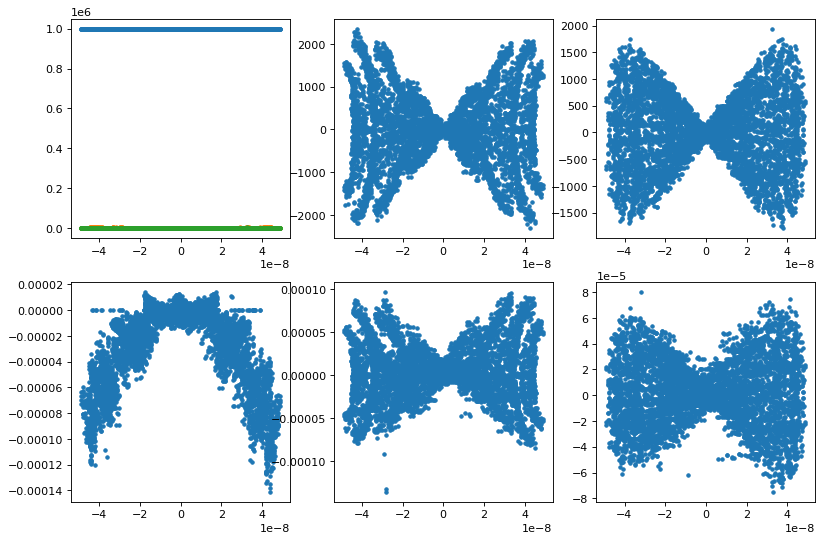

In [19]:
mids2d=compute_mids2d(mesh['nodes'],mesh['faces'],dist_factor=1.0)
on_outer_faces=mesh['on_outer_faces']

fig,ax=plt.subplots(2,3,figsize=(12,8),dpi=80)
axs=ax.flatten()
axs[0].plot(mids2d[on_outer_faces,0],np.real(tmp[on_outer_faces,1]),'.')
axs[0].plot(mids2d[on_outer_faces,0],np.real(tmp[on_outer_faces,2]),'.')
axs[0].plot(mids2d[on_outer_faces,0],np.real(tmp[on_outer_faces,3]),'.')

axs[1].plot(mids2d[on_outer_faces,0],np.real(tmp[on_outer_faces,2]),'.')
axs[2].plot(mids2d[on_outer_faces,0],np.real(tmp[on_outer_faces,3]),'.')

axs[3].plot(mids2d[on_outer_faces,0],np.imag(tmp[on_outer_faces,1]),'.')
axs[4].plot(mids2d[on_outer_faces,0],np.imag(tmp[on_outer_faces,2]),'.')
axs[5].plot(mids2d[on_outer_faces,0],np.imag(tmp[on_outer_faces,3]),'.')

# Sphere model

## Radial discretization

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt

a=5e-6
#debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
debye_len=np.sqrt(perm0*80*kB*293/2/1**2/echarge**2/kA/1)
print('DEBYE LENGTH IS: %.2e nm'%(debye_len*1e9))
print('Ratio of radius to debye length IS:',a/debye_len)

def spherical2cartesian(rho,theta,phi): #3D space
    x=rho*np.cos(phi)*np.sin(theta)
    y=rho*np.sin(phi)*np.sin(theta)
    z=rho*np.cos(theta)
    return x,y,z

def polar2cartesian(rho,phi): #2D plane
    x=rho*np.cos(phi)
    y=rho*np.sin(phi)
    return x,y

if __name__=='__main__':
    #radial discretization in the solid
    n1=1
    dx1=np.array([5e-6])
    
    #radial discretization at the solid-liquid interface
    dr_min=debye_len/2
    dr_max=debye_len*1.8
    n2=8
    dx2=np.logspace(np.log10(dr_min),np.log10(dr_max*1.8),n2)
    
    #radial discretization in the liquid
    dr_min=max(debye_len/2,np.pi*a/400)
    dr_max=10*a/20
    n3=2
    while 1:
        dx3=np.logspace(np.log10(dr_min),np.log10(dr_max),n3)
        if (np.sum(dx2)+np.sum(dx3)+a)<10*a:
            n3=n3+1
        else:
            break
    
    #radial points in the solid
    rho=np.zeros(n1+n2+n3+1)
    rho[0]=0.0
    rho[1]=5e-6
    
    #radial points at the solid-liquid interface
    for i in range(len(dx2)):
        rho[i+n1+1]=rho[i+n1]+dx2[i]
    
    #discretization in the liquid
    for i in range(len(dx3)):
        rho[i+n1+n2+1]=rho[i+n1+n2]+dx3[i]
    rho[n1+n2+n3]=10*a #adjust ending point
    dx3[n3-1]=rho[n1+n2+n3]-rho[n1+n2+n3-1]
    print('Done')

DEBYE LENGTH IS: 9.63e+00 nm
Ratio of radius to debye length IS: 519.3625269371644
Done


## Mesh generation

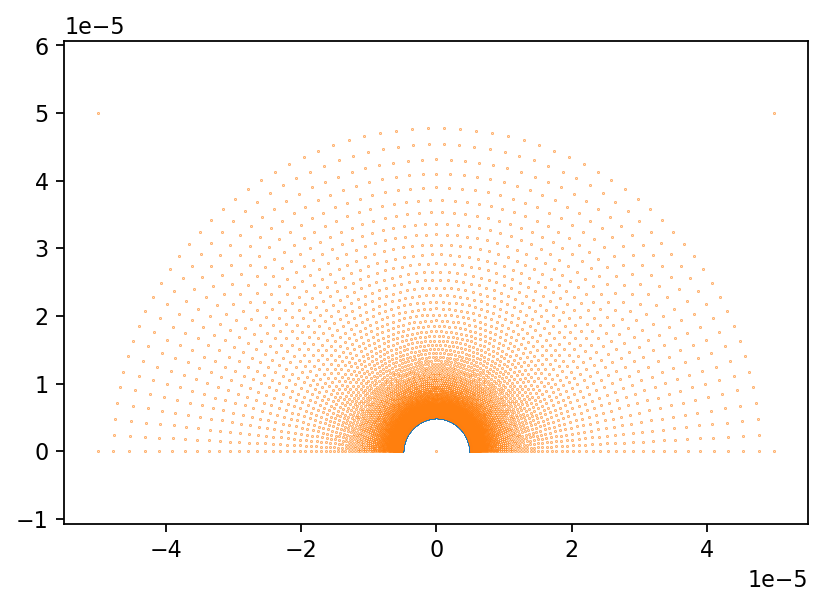

In [30]:
if __name__=='__main__':
    #number of points in sphere
    ns = 401-2 #resulting dr=np.pi*a/400
    
    #define sphere points
    s1p = np.zeros((ns,2))
    
    dA = np.pi/(ns+2-1)
    
    for i in range(ns):
        s1p[i,0] = a*np.cos((i+1)*dA)
        s1p[i,1] = a*np.sin((i+1)*dA)
        
    #define refined sphere points
    sp_refined = np.zeros((ns*n2,2))
    
    for i in range(n2):
        phi = np.arange(1,ns+1)*dA
        sp_refined[i*ns:(i+1)*ns,0] = rho[i+n1+1]*np.cos(phi)
        sp_refined[i*ns:(i+1)*ns,1] = rho[i+n1+1]*np.sin(phi)
                
    #define the corner points
    cp = np.zeros((2*len(rho)+1,2))
    
    #outer boundary points
    cp[:,0] = np.r_[np.flipud(-rho),rho[1:],[10*a,-10*a]]
    cp[:,1] = np.r_[np.zeros(len(rho)*2-1),[10*a,10*a]]
    
    #define refined corner points
    cp_refined = np.zeros((0,2))
    
    for i in range(n3-1):
        nA = int(np.pi/dx3[i]*rho[i+n1+n2+1])+1-2
        dA = np.pi/(nA+2-1)
        phi = np.arange(1,nA+1)*dA
        x = rho[i+n1+n2+1]*np.cos(phi)
        y = rho[i+n1+n2+1]*np.sin(phi)
        cp_refined = np.r_[cp_refined,np.c_[x,y]]
    
#     for i in range(n3-1):
#         nx = int(2*rho[i+n1+n2+1]/dx3[i])+1
#         dx = 2*rho[i+n1+n2+1]/(nx-1)
#         x = np.arange(nx)*dx-rho[i+n1+n2+1]
#         y = np.zeros_like(x)+rho[i+n1+n2+1]
#         cp_refined = np.r_[cp_refined,np.c_[x,y]]
        
#         ny = int(rho[i+n1+n2+1]/dx3[i])+1
#         dy = rho[i+n1+n2+1]/(ny-1)
#         y = np.arange(1,ny-1)*dy
#         x = np.zeros_like(y)+rho[i+n1+n2+1]
#         cp_refined = np.r_[cp_refined,np.c_[x,y]]
#         cp_refined = np.r_[cp_refined,np.c_[-x,y]]
    
    
    #define the segments
    segs = []
    
    segs.append([np.argmin((cp[:,0]-a)**2)+ns,0])
    
    for i in range(0,ns-1):
        segs.append([i,i+1])
    
    segs.append([ns-1,np.argmin((cp[:,0]+a)**2)+ns])
        
    for i in range(ns,ns+2*len(rho)+1):
        segs.append([i,i+1])
    segs[ns+1+2*len(rho)][1] = ns
    
    #build the poly file
    f1 = open('spheres_2d.poly','w')
    f1.write(str(ns+2*len(rho)+1+ns*n2+len(cp_refined))+'  2 0 1  #verticies #dimensions  #attributes #boundary markers \n')
    
    #write the vertices
    cnt = 1
    f1.write('# Sphere 1 points. The boundary marker for sphere 1 is 1\n')
    for i in range(ns):
        f1.write("{0:6.0F} {1:10.5F} {2:10.5F} 1\n".format(cnt,s1p[i,0]*1e6,s1p[i,1]*1e6))
        cnt=cnt+1
    
    f1.write('# Outer boundary points. The boundary marker is 3\n')
    for i in range(2*len(rho)+1):
        f1.write("{0:6.0F} {1:10.5F} {2:10.5F} 3\n".format(cnt,cp[i,0]*1e6,cp[i,1]*1e6))
        cnt = cnt+1
    f1.write('\n\n')
    
    f1.write('# Refined sphere points. The boundary marker is 0\n')
    for i in range(ns*n2):
        f1.write("{0:6.0F} {1:10.5F} {2:10.5F} 0\n".format(cnt,sp_refined[i,0]*1e6,sp_refined[i,1]*1e6))
        cnt=cnt+1
    f1.write('\n\n')

    f1.write('# Refined corner points. The boundary marker is 0\n')
    for i in range(len(cp_refined)):
        f1.write("{0:6.0F} {1:10.5F} {2:10.5F} 0\n".format(cnt,cp_refined[i,0]*1e6,cp_refined[i,1]*1e6))
        cnt=cnt+1
    f1.write('\n\n')
    
    #write the segments
    f1.write(str(len(segs))+' 1 #segments, boundary marker\n')
    for i in range(ns+1):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} 1\n".format(i+1,segs[i][0]+1,segs[i][1]+1))

    for i in range(ns+1,ns+1+2*len(rho)-2):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} 3\n".format(i+1,segs[i][0]+1,segs[i][1]+1))
    
    i = ns+1+2*len(rho)-2
    f1.write("{0:6.0F} {1:5.0F} {2:5.0F} 4\n".format(i+1,segs[i][0]+1,segs[i][1]+1))
    
    i = ns+1+2*len(rho)-1
    f1.write("{0:6.0F} {1:5.0F} {2:5.0F} 5\n".format(i+1,segs[i][0]+1,segs[i][1]+1))
    
    i = ns+1+2*len(rho)
    f1.write("{0:6.0F} {1:5.0F} {2:5.0F} 6\n".format(i+1,segs[i][0]+1,segs[i][1]+1))

    #holes
    f1.write('\n\n0\n\n')

    #area constraints for each of 2 zones
    f1.write('2\n')
    f1.write('1 {0:12.6F} {1:12.6F} 1 {2:12.6F}\n'.format(0.0,1.0,0.1))
    f1.write('2 {0:12.6F} {1:12.6F} 2 {2:12.6F}\n'.format(0.0,10.0,(a/2)**3))

    f1.write('# triangle -pnq30Aae spheres_2d.poly \n')
    f1.close()

    fig,ax=plt.subplots(dpi=160)
    ax.plot(s1p[:,0],s1p[:,1],'.',markersize=0.5)
    ax.plot(cp[:,0],cp[:,1],'.',markersize=0.5)
    ax.plot(sp_refined[:,0],sp_refined[:,1],'.',markersize=0.5,color='tab:blue')
    ax.plot(cp_refined[:,0],cp_refined[:,1],'.',markersize=0.5,color='tab:orange')
    ax.axis('equal')
#     ax.set_xlim(5e-6,5.25e-6)
#     ax.set_ylim(0,0.25e-6)
    plt.show()

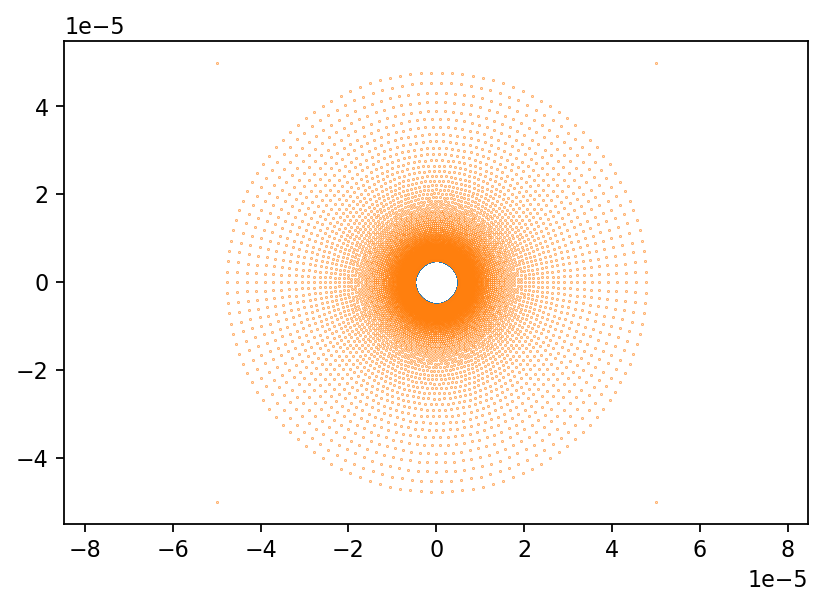

In [87]:
if __name__=='__main__':
    #number of points in sphere
    ns = 800 #resulting dr=np.pi*a/400
    
    #define sphere points
    s1p = np.zeros((ns,2))
    
    dA = 2*np.pi/ns
    
    for i in range(ns):
        s1p[i,0] = a*np.cos(i*dA)
        s1p[i,1] = a*np.sin(i*dA)
        
    #define refined sphere points
    sp_refined = np.zeros((ns*n2,2))
    
    for i in range(n2):
        phi = np.arange(ns)*dA
        sp_refined[i*ns:(i+1)*ns,0] = rho[i+n1+1]*np.cos(phi)
        sp_refined[i*ns:(i+1)*ns,1] = rho[i+n1+1]*np.sin(phi)
                
    #define the corner points
    cp = np.zeros((4,2))
    cp[:,0] = [-10*a,10*a,10*a,-10*a]
    cp[:,1] = [-10*a,-10*a,10*a,10*a]

#     for i in range(4):
#         cp[i,0] = 10*a*np.cos(i*np.pi/2 + np.pi/4)
#         cp[i,1] = 10*a*np.sin(i*np.pi/2 + np.pi/4)
    
    #define refined corner points
    cp_refined = np.zeros((0,2))
    
    for i in range(n3-1):
        nA = 2*int(np.pi/dx3[i]*rho[i+n1+n2+1])
        dA = 2*np.pi/nA
        phi = np.arange(nA)*dA
        x = rho[i+n1+n2+1]*np.cos(phi)
        y = rho[i+n1+n2+1]*np.sin(phi)
        cp_refined = np.r_[cp_refined,np.c_[x,y]]
        
    
    #define the segments
    segs = []

    for i in range(ns):
        segs.append([i,i+1])
    segs[ns-1][1]=0

    for i in range(4):
        segs.append([ns+i,ns+i+1])
    segs[ns+3][1] = ns
    
    #build the poly file
    f1 = open('spheres_2d.poly','w')
    f1.write(str(ns+4+len(sp_refined)+len(cp_refined))+'  2 0 1  #verticies #dimensions  #attributes #boundary markers \n')
    
    #write the vertices
    cnt = 1
    f1.write('# Sphere 1 points. The boundary marker for sphere 1 is 1\n')
    for i in range(ns):
        f1.write("{0:6.0F} {1:10.5F} {2:10.5F} 1\n".format(cnt,s1p[i,0]*1e6,s1p[i,1]*1e6))
        cnt=cnt+1
    
    f1.write('# Outer boundary points. The boundary marker is 3\n')
    for i in range(4):
        f1.write("{0:6.0F} {1:10.5F} {2:10.5F} 3\n".format(cnt,cp[i,0]*1e6,cp[i,1]*1e6))
        cnt = cnt+1
    
    f1.write('# Refined sphere points. The boundary marker is 0\n')
    for i in range(len(sp_refined)):
        f1.write("{0:6.0F} {1:10.5F} {2:10.5F} 0\n".format(cnt,sp_refined[i,0]*1e6,sp_refined[i,1]*1e6))
        cnt=cnt+1

    f1.write('# Refined corner points. The boundary marker is 0\n')
    for i in range(len(cp_refined)):
        f1.write("{0:6.0F} {1:10.5F} {2:10.5F} 0\n".format(cnt,cp_refined[i,0]*1e6,cp_refined[i,1]*1e6))
        cnt=cnt+1
    f1.write('\n\n')
    
    #write the segments
    f1.write(str(len(segs))+' 1 #segments, boundary marker\n')
    for i in range(ns):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} 1\n".format(i+1,segs[i][0]+1,segs[i][1]+1))

    for i in range(ns,ns+4):
        f1.write("{0:6.0F} {1:5.0F} {2:5.0F} 3\n".format(i+1,segs[i][0]+1,segs[i][1]+1))          

    #holes
    f1.write('\n\n0\n\n')

    #area constraints for each of 2 zones
    f1.write('2\n')
    f1.write('1 {0:12.6F} {1:12.6F} 1 {2:12.6F}\n'.format(0.0,1.0,0.1))
    f1.write('2 {0:12.6F} {1:12.6F} 2 {2:12.6F}\n'.format(0.0,10.0,(a/2)**3))

    f1.write('# triangle -pnq30Aae spheres_2d.poly \n')
    f1.close()

    fig,ax=plt.subplots(dpi=160)
    ax.plot(s1p[:,0],s1p[:,1],'.',markersize=0.5)
    ax.plot(cp[:,0],cp[:,1],'.',markersize=0.5)
    ax.plot(sp_refined[:,0],sp_refined[:,1],'.',markersize=0.5,color='tab:blue')
    ax.plot(cp_refined[:,0],cp_refined[:,1],'.',markersize=0.5,color='tab:orange')
    ax.axis('equal')
#     ax.set_xlim(5e-6,5.25e-6)
#     ax.set_ylim(0,0.25e-6)
    plt.show()

## Mesh visualization

Reading spheres_2d.1.node
Reading spheres_2d.1.ele
Reading spheres_2d.1.edge
THE NUMBER OF NODES IS: 22398
THE NUMBER OF ELEMENTS IS: 44543
THE NUMBER OF EDGES IS: 66940



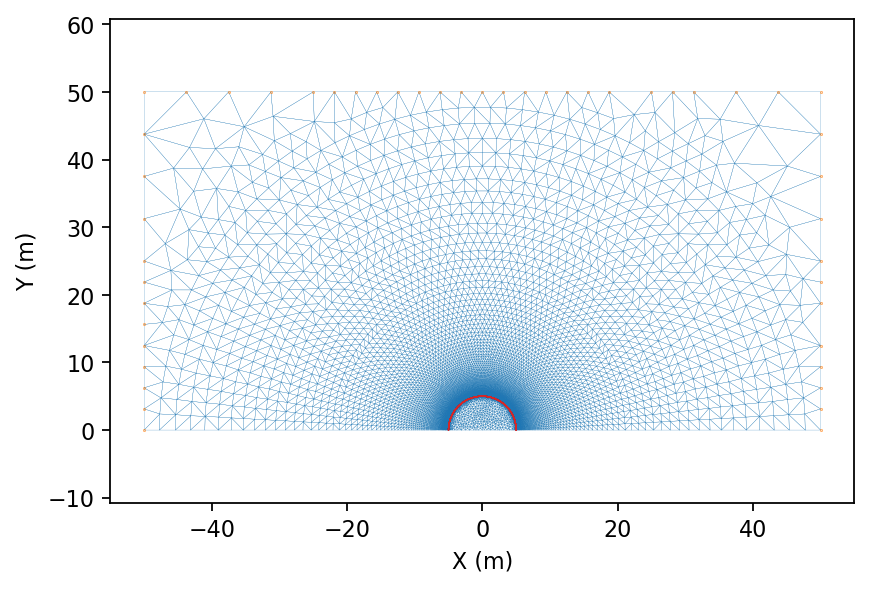

In [6]:
def display_mesh():
    #modify user inputs below
    mesh_prefix='spheres_2d'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1
    
    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('')
    
    fig,ax=plt.subplots(dpi=160)
    mask=zones>=1 #select zones to display
    x=nodes[elements[:,[0,1,2,0]],0]
    y=nodes[elements[:,[0,1,2,0]],1]
    ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.1,color='tab:blue')    
    
#     mask=edge_flags==1
#     x=nodes[edges,0]
#     y=nodes[edges,1]
#     ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:green')
    
#     mask=edge_flags==2
#     x=nodes[edges,0]
#     y=nodes[edges,1]
#     ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:red')

#     mask=edge_flags==3
#     x=nodes[edges,0]
#     y=nodes[edges,1]
#     ax.plot(x[mask,:].T,y[mask,:].T,'-',linewidth=0.5,color='tab:orange')

#     mask=node_flags==1
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:green')
#     mask=node_flags==2
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:red')
#     mask=node_flags==3
#     ax.plot(nodes[mask,0],nodes[mask,1],'.',markersize=1,color='tab:orange')
    
#     ax.plot(sp_refined[:,0]*1e6,sp_refined[:,1]*1e6,'.')
#     ax.plot(cp_refined[:,0]*1e6,cp_refined[:,1]*1e6,'.',color='tab:orange',markersize=0.5)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.axis('equal')
#     ax.set_xlim(5,5.25)
#     ax.set_ylim(0,0.25)
    return fig,ax

if __name__=='__main__':
    fig,ax=display_mesh()
    nodes=mesh['nodes']
    elements=mesh['elements']
    edges=mesh['edges']
    with_first_kind_bc=mesh['with_first_kind_bc']
    with_third_kind_bc=mesh['with_third_kind_bc']
    in_stern=mesh['in_stern']
    
    nind_bc=np.unique(edges[with_first_kind_bc,:].flatten(order='C'))
    x=nodes[nind_bc,0]*1e6
    y=nodes[nind_bc,1]*1e6
    ax.plot(x,y,'.',color='tab:orange',markersize=0.5)
    
    x=nodes[edges[with_third_kind_bc,:],0]*1e6
    y=nodes[edges[with_third_kind_bc,:],1]*1e6
    ax.plot(x.T,y.T,'-',linewidth=0.5,color='tab:red')
    plt.show()

## Mesh properties

In [124]:
import numpy as np

def set_mesh():
    #modify user inputs below
    mesh_prefix='spheres_2d'
    
    #load mesh
    print('Reading %s.1.node'%mesh_prefix)
    nodes=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=(1,2))
    node_flags=np.genfromtxt(mesh_prefix+'.1.node',skip_header=1,skip_footer=0,usecols=3,dtype='int')

    print('Reading %s.1.ele'%mesh_prefix)
    elements=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=(1,2,3),dtype='int')
    zones=np.genfromtxt(mesh_prefix+'.1.ele',skip_header=1,usecols=4,dtype='int')

    print('Reading %s.1.edge'%mesh_prefix)
    edges=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=(1,2),dtype='int')
    edge_flags=np.genfromtxt(mesh_prefix+'.1.edge',skip_header=1,usecols=3,dtype='int')

    #adjust indices to start from zero
    elements=elements-1
    edges=edges-1

    #scale nodes from meter to micro-meter
    nodes=nodes*1e-6

    nnode=len(nodes)
    nelem=len(elements)
    nedge=len(edges)
    print('THE NUMBER OF NODES IS: %d'%nnode)
    print('THE NUMBER OF ELEMENTS IS: %d'%nelem)
    print('THE NUMBER OF EDGES IS: %d'%nedge)
    print('')

    #define computational elements and boundaries
    in_active_zones=zones>=1 #True for elements used in computation
    #with_first_kind_bc=(edge_flags>=4)|(edge_flags==1) #True for nodes on first kind b.c.
    with_first_kind_bc=edge_flags>=4 #True for nodes on first kind b.c.
    with_third_kind_bc=edge_flags==1 #True for faces on third kind b.c.

    #define electrolyte,solid,stern layer
    in_electrolyte=zones==2
    in_solid=zones==1
    in_stern=edge_flags==1
    
    #more properties
    with_inner_bound=edge_flags==1
    with_outer_bound=edge_flags>=3
    with_top_bound=edge_flags==5
    with_bottom_bound=edge_flags==3
    with_left_bound=edge_flags==6
    with_right_bound=edge_flags==4

    nind_active=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_bc=np.unique(edges[with_first_kind_bc,:].flatten(order='C'))
    print('THE NUMBER OF ACTIVE NODES IS:',len(nind_active))
    print('THE NUMBER OF ACTIVE ELEMENTS IS:',np.count_nonzero(in_active_zones))
    print('THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS:',len(nind_bc))
    print('THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS:',np.count_nonzero(with_third_kind_bc))
    print('')
    
    mesh={'elements':elements,'nodes':nodes,'edges':edges,
          'in_active_zones':in_active_zones,
          'with_first_kind_bc':with_first_kind_bc,
          'with_third_kind_bc':with_third_kind_bc,
          'in_electrolyte':in_electrolyte,
          'in_solid':in_solid,
          'in_stern':in_stern,
          'with_inner_bound':with_inner_bound,
          'with_outer_bound':with_outer_bound,
          'with_top_bound':with_top_bound,
          'with_bottom_bound':with_bottom_bound,
          'with_left_bound':with_left_bound,
          'with_right_bound':with_right_bound}
    
    return mesh

def set_physics():
    rel_perm_electrolyte=80.0 #relative permittivity of bulk electrolyte [F/m]
    rel_perm_solid=4.5 #relative permittivity of solid particle [F/m]
    #diffusion_electrolyte=2*1e-9 #diffusion coefficient of water at 20 deg. C is 2*(1e-6*m)^2/(1e-3*s)
    #diffusion_stern=2*1e-10 #diffusion coefficient in Stern layer [m^2/s]
    mobility_electrolyte=5e-8 #mobility of sodium cation in bulk electrolyte [m^2/(Vs)]
    mobility_stern=5e-9 #mobility in Stern layer [m^2/(Vs)]
    sigma_solid=-0.01 #surface charge density in solid [C/m^2]
    
    temp_K=293 #room/ambient temperature [K]
    cinf=1.0e-2 #ion concentration in bulk electrolyte [mol/m^3]
    zval=1 #ion valence in bulk electrolyte
    # cinf_pos=0.01 #ion concentration of positive charges
    # cinf_neg=0.01 #ion concentration of negative charges
    # zval_pos=1 #positive ion valence
    # zval_neg=1 #negative ion valence
    
    #diffusion coefficient based on Einstein relation
    diffusion_electrolyte=mobility_electrolyte*kB*temp_K/echarge
    diffusion_stern=mobility_stern*kB*temp_K/echarge

    print('Compute distance scaling factor using Debye length')
    debye_len=np.sqrt(perm0*rel_perm_electrolyte*kB*temp_K/2/zval**2/echarge**2/kA/cinf)
    dist_factor=10**(-round(np.log10(debye_len))) #to be determined from debye length
    print('DEBYE LENGTH IS: %.2e m'%debye_len)
    print('SUGGESTED DISTANCE SCALING FACTOR IS: %.2e'%dist_factor)
    print('')
    
    print('RELATIVE PERMITTIVITY OF ELECTROLYTE IS:',rel_perm_electrolyte)
    print('RELATIVE PERMITTIVITY OF SOLID IS:',rel_perm_solid)
    print('DIFFUSION COEFFICIENT OF ELECTROLYTE IS:',diffusion_electrolyte)
    print('DIFFUSION COEFFICIENT OF STERN LAYER IS:',diffusion_stern)
    print('ION MOBILITY IN ELECTROLYTE IS:',mobility_electrolyte)
    print('ION MOBILITY IN STERN LAYER IS:',mobility_stern)
    print('SURFACE CHARGE DENSITY FOR SOLID IS:',sigma_solid)
    print('TEMPERATURE IS:',temp_K)
    print('ION COCENTRATION AT INFINITY IS:',cinf)
    print('ION VALENCE IS:',zval)
    print('')
    
    physics={'rel_perm_electrolyte':rel_perm_electrolyte,'rel_perm_solid':rel_perm_solid,
             'diffusion_electrolyte':diffusion_electrolyte,'diffusion_stern':diffusion_stern,
             'mobility_electrolyte':mobility_electrolyte,'mobility_stern':mobility_stern,
             'sigma_solid':sigma_solid,'debye_len':debye_len,
             'sigma_electrolyte':None,'sigma_stern':None,
             'temperature':temp_K,'ion_conc_inf':cinf,'ion_val':zval}
    
    return physics

if __name__=='__main__':
    mesh=set_mesh()
    physics=set_physics()
    print('Done')

Reading spheres_2d.1.node
Reading spheres_2d.1.ele
Reading spheres_2d.1.edge
THE NUMBER OF NODES IS: 22398
THE NUMBER OF ELEMENTS IS: 44543
THE NUMBER OF EDGES IS: 66940

THE NUMBER OF ACTIVE NODES IS: 22398
THE NUMBER OF ACTIVE ELEMENTS IS: 44543
THE NUMBER OF NODES ON DIRICHLET BOUNDARY IS: 48
THE NUMBER OF ELEMENTS ON ROBIN BOUNDARY IS: 1811

Compute distance scaling factor using Debye length
DEBYE LENGTH IS: 9.63e-08 m
SUGGESTED DISTANCE SCALING FACTOR IS: 1.00e+07

RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 80.0
RELATIVE PERMITTIVITY OF SOLID IS: 4.5
DIFFUSION COEFFICIENT OF ELECTROLYTE IS: 1.2628995006242197e-09
DIFFUSION COEFFICIENT OF STERN LAYER IS: 1.2628995006242196e-10
ION MOBILITY IN ELECTROLYTE IS: 5e-08
ION MOBILITY IN STERN LAYER IS: 5e-09
SURFACE CHARGE DENSITY FOR SOLID IS: -0.01
TEMPERATURE IS: 293
ION COCENTRATION AT INFINITY IS: 0.01
ION VALENCE IS: 1

Done


## Static solution

In [88]:
def set_materials1d(mesh,physics,u1d,freq,case): #modified from set_materials2d
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    c=np.zeros(nedge,dtype=complex)
    alpha_x=np.zeros(nedge,dtype=complex)
    alpha_y=np.zeros(nedge,dtype=complex)
    alpha_z=np.zeros(nedge,dtype=complex)

    beta_x=np.zeros(nedge,dtype=complex)
    beta_y=np.zeros(nedge,dtype=complex)
    beta_z=np.zeros(nedge,dtype=complex)

    gamma_x=np.zeros(nedge,dtype=complex)
    gamma_y=np.zeros(nedge,dtype=complex)
    gamma_z=np.zeros(nedge,dtype=complex)

    a=np.zeros(nedge,dtype=complex)
    f=np.zeros(nedge,dtype=complex)
    gs=0 #placeholder; not implemented yet
    qs=0 #placeholder; not implemented yet
    snod=0 #placeholder; not implemented yet
    anod=0 #placeholder; not implemented yet
    fnod=0 #placeholder; not implemented yet

    c[in_stern]=physics['diffusion_stern']
    gamma_x[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_y[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    gamma_z[in_stern]=-physics['mobility_stern']*physics['sigma_stern']
    a[in_stern]=1j

    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials
    
def set_materials2d(mesh,physics,u2d,freq,case): #modified from set_materials3d
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])

    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']

    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']

    c=np.zeros(nelem,dtype=complex)
    alpha_x=np.zeros(nelem,dtype=complex)
    alpha_y=np.zeros(nelem,dtype=complex)
    alpha_z=np.zeros(nelem,dtype=complex)

    beta_x=np.zeros(nelem,dtype=complex)
    beta_y=np.zeros(nelem,dtype=complex)
    beta_z=np.zeros(nelem,dtype=complex)

    gamma_x=np.zeros(nelem,dtype=complex)
    gamma_y=np.zeros(nelem,dtype=complex)
    gamma_z=np.zeros(nelem,dtype=complex)

    a=np.zeros(nelem,dtype=complex)
    f=np.zeros(nelem,dtype=complex)
    gs=np.zeros(nedge,dtype=complex)
    qs=np.zeros(nedge,dtype=complex)
    snod=np.zeros(nnode,dtype=complex)
    anod=np.zeros(nnode,dtype=complex)
    fnod=np.zeros(nnode,dtype=complex)

    mids1d=compute_mids1d(mesh['nodes'],mesh['edges'],dist_factor=1.0)
    mids2d=compute_mids2d(mesh['nodes'],mesh['elements'],dist_factor=1.0)
    mids1d[:,:]=1.0
    mids2d[:,:]=1.0
    c[in_electrolyte]=perm0*physics['rel_perm_electrolyte']*mids2d[in_electrolyte,1]
    c[in_solid]=perm0*physics['rel_perm_solid']*mids2d[in_solid,1]
    gs[in_stern]=-physics['sigma_electrolyte']*mids1d[in_stern,1]

    ze=zval*echarge #ion valence times elementary charge
    u2d_scale=ze*u2d[:,0]/kB/temp_K #scaled potential in elements
    a[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(u2d_scale)*mids2d[:,1]
    f[:]=-2*ze*kA*cinf*(np.sinh(u2d_scale)-np.cosh(u2d_scale)*u2d_scale)*mids2d[:,1]
    a[in_solid]=0
    f[in_solid]=0

#     elements=mesh['elements']
#     unod_scale=np.zeros(nnode)
#     anod[:]=2*ze**2*kA*cinf/kB/temp_K*np.cosh(unod_scale)
#     fnod[:]=-2*ze*kA*cinf*(np.sinh(unod_scale)-np.cosh(unod_scale)*unod_scale)
#     nind_solid=np.unique(elements[in_solid].flatten(order='C'))
#     anod[nind_solid]=0
#     fnod[nind_solid]=0

#     edges=mesh['edges']
#     with_inner_bound=mesh['with_inner_bound']
#     nind_bc=np.unique(edges[with_inner_bound,:].flatten(order='C'))
#     snod[nind_bc]=-physics['sigma_electrolyte'] #temporarily use sigma value as potential
#     print('snod',snod[nind_bc])
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}

    return materials

def build_system(mesh,materials1d,materials2d,case):
    nnode=len(mesh['nodes'])
    K=csr_matrix((nnode,nnode))
    b=np.zeros(nnode,dtype=complex)
    K,b=assemble_Ke2d(mesh,materials2d,K,b,offset=(0,0),nrep=1)
    K,b=assemble_Ks2d(mesh,materials2d,K,b,offset=(0,0),nrep=1)
    K,b=set_first_kind_bc2d(mesh,materials2d,K,b,offset=(0,0),nrep=1)
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(0,0),nrep=1)

    return K,b

if __name__=='__main__':
    #user input
    #meshfile='sphere_s61_electrolyte.hdf5'
    #physfile='sphere_s61_electrolyte.hdf5'    
    srvfile='not_exit.srv'
    dist_factor=1

    #setup mesh and material properties
    #mesh=import_mesh(meshfile)
    #physics=import_physics(physfile)
    ratio=0.8
    physics['sigma_electrolyte']=-(1-ratio)*physics['sigma_solid']
    physics['sigma_stern']=-ratio*physics['sigma_solid']
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',physics['sigma_electrolyte'])
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',physics['sigma_stern'])
    print('')
    
    #initialize mesh variables
    nodes=mesh['nodes']
    elements=mesh['elements']
    edges=mesh['edges']

    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_active=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(edges[in_stern,:].flatten(order='C'))
    
    #run iterative simulation
    u1d=np.zeros((len(edges),3))
    u2d=np.zeros((len(elements),3))
    unod=np.zeros(len(nodes),dtype=complex)
    unod_1=np.zeros(len(nodes),dtype=complex)
    materials1d=set_materials1d(mesh,physics,u1d,freq=None,case=1)
    materials2d=set_materials2d(mesh,physics,u2d,freq=None,case=1)
    mesh_scale=scale_mesh(mesh,dist_factor)
    sigma_max=np.max(np.abs(materials2d['gs']))
    sigma_min=np.minimum(0.002e-2,sigma_max)
    materials2d['gs']=materials2d['gs']/sigma_max*sigma_min
    for i in range(20):
        print('==================== ITERATION #',i+1,' ====================')
        print('')
        print('sigma_min',sigma_min,'sigma_max',sigma_max)
        materials1d_scale=scale_materials(materials1d,dist_factor)
        materials2d_scale=scale_materials(materials2d,dist_factor)
        K,b=build_system(mesh_scale,materials1d_scale,materials2d_scale,case=1)
        unod_1[:]=unod
        unod[:]=solve_unod(K/perm0,b/perm0)
        rel_error=np.linalg.norm(unod-unod_1)/np.linalg.norm(unod)
        print('Relative error is',rel_error)
        if (sigma_min==sigma_max)&(rel_error<0.05):
            print('Solution is converged')
            print('')
            break
        print('')
        u2d=grad2d(nodes,elements,unod,dist_factor=dist_factor)
        materials2d=set_materials2d(mesh,physics,u2d,freq=None,case=1)
        sigma_min=np.minimum(sigma_min*5,sigma_max)
        materials2d['gs']=materials2d['gs']/sigma_max*sigma_min
        

    #unod=reshape_unod(unod,nrep=1)
    #output=output_unod(nodes,unod[:,0],srvfile)

    np.save('sphere_s62',unod)
    print('Done')

SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: 0.0019999999999999996
SURFACE CHARGE DENSITY FOR STERN LAYER IS: 0.008

TEST CASE IS: 1
Setting material properties in Stern layer

TEST CASE IS: 1
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+00

==================== ITERATION # 1  ====================

sigma_min 2e-05 sigma_max 0.0019999999999999996
Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Assembling the system of equations
Time elapsed  5.305478572845459 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.06256318092346191 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  4.919111490249634 sec

Setting the unkonwns on inactive nodes as zeros
Time elapsed  0.029343366622924805 sec

Calling sparse linear system solver
Time elapsed  0.17326736450195312 sec

Relative error is 1.0

Computing fiel

Computing 1D linar PB solution in spherical coordinates
SOLID PARTICLE RADIUS IS: 5e-06
RELATIVE PERMITTIVITY OF ELECTROLYTE IS: 80
TEMPERATURE IS: 293
ION COCENTRATION AT INFINITY IS: 0.01
ION VALENCE IS: 1
SURFACE CHARGE DENSITY AT SPHERE IS: -0.002
DEBYE LENGTH IS: 96.27186677264704 nm



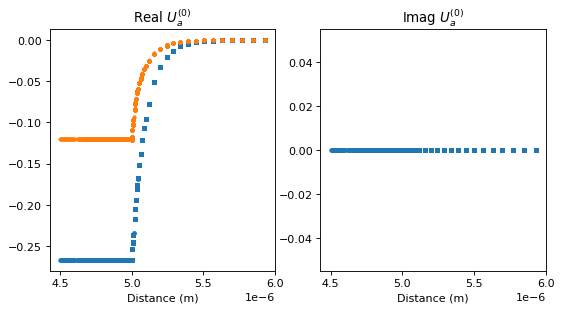

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    ansol=ansol_sphere(np.c_[nodes,np.zeros(nodes.shape[0])],a=a,rel_perm=80,
                       temp_K=293,cinf=1e-2,zval=1,zeta=-0.002,gradflag=True)
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2)
    mask=(dist>=0.9*a)&(dist<=1.2*a)
    axs[0].plot(dist[mask],np.real(ansol[mask,0]),'.')
    axs[0].plot(dist[mask],np.real(unod[mask]),'.',markersize=5)
#     axs[0].plot(dist[mask],np.real(unod[mask]-ansol[mask,0]),'.',markersize=5)
#     mask=(rho>=0.9*a)&(rho<=(a+100*debye_len))
#     axs[0].plot(nodes[484:484+8,0],np.real(ansol[484:484+8,0]),'*')
#     axs[0].plot(nodes[484:484+8,0],np.real(unod[484:484+8]),'*')
    axs[1].plot(dist[mask],np.imag(ansol[mask,0]),'.')
    
    axs[0].set_xlabel('Distance (m)')
    axs[1].set_xlabel('Distance (m)')
    axs[0].set_title('Real $U^{(0)}_a$')
    axs[1].set_title('Imag $U^{(0)}_a$')
    plt.show()

## Perturbed solution

In [213]:
e0=1e2

def set_materials1d(mesh,physics,u1d,freq,case): #modified from set_materials2d
    print('TEST CASE IS:',case)
    print('Setting material properties in Stern layer')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
        
    c=np.zeros((nedge,3,3),dtype=complex)
    alpha_x=np.zeros((nedge,3,3),dtype=complex)
    alpha_y=np.zeros((nedge,3,3),dtype=complex)
    alpha_z=np.zeros((nedge,3,3),dtype=complex)

    beta_x=np.zeros((nedge,3,3),dtype=complex)
    beta_y=np.zeros((nedge,3,3),dtype=complex)
    beta_z=np.zeros((nedge,3,3),dtype=complex)

    gamma_x=np.zeros((nedge,3),dtype=complex)
    gamma_y=np.zeros((nedge,3),dtype=complex)
    gamma_z=np.zeros((nedge,3),dtype=complex)

    a=np.zeros((nedge,3,3),dtype=complex)
    f=np.zeros((nedge,3),dtype=complex)
    gs=0j #placeholder; not implemented yet
    qs=0j #placeholder; not implemented yet
    snod=0j #placeholder; not implemented yet
    anod=0 #placeholder; not implemented yet
    fnod=0 #placeholder; not implemented yet

    mids1d=compute_mids1d(mesh['nodes'],mesh['edges'],dist_factor=1.0)
    c[in_stern,2,2]=physics['diffusion_stern']*mids1d[in_stern,1]
    gamma_x[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern']*mids1d[in_stern,1] #coupled coefficient
    #gamma_y[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    #gamma_z[in_stern,2]=-physics['mobility_stern']*physics['sigma_stern'] #coupled coefficient
    a[in_stern,0,0]=1j*freq*mids1d[in_stern,1]
    a[in_stern,1,1]=1j*freq*mids1d[in_stern,1]
    a[in_stern,2,2]=1j*freq*mids1d[in_stern,1]
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def set_materials2d(mesh,physics,u3d,freq,case): #modified from set_materials3d
    print('TEST CASE IS:',case)
    print('Setting material properties in solid and electrolyte')
    print('')
    nelem=len(mesh['elements'])
    nnode=len(mesh['nodes'])
    nedge=len(mesh['edges'])
    
    in_electrolyte=mesh['in_electrolyte']
    in_solid=mesh['in_solid']
    in_stern=mesh['in_stern']
    
    temp_K=physics['temperature']
    cinf=physics['ion_conc_inf']
    zval=physics['ion_val']
    
    c=np.zeros((nelem,3,3),dtype=complex)
    alpha_x=np.zeros((nelem,3,3),dtype=complex)
    alpha_y=np.zeros((nelem,3,3),dtype=complex)
    alpha_z=np.zeros((nelem,3,3),dtype=complex)

    beta_x=np.zeros((nelem,3,3),dtype=complex)
    beta_y=np.zeros((nelem,3,3),dtype=complex)
    beta_z=np.zeros((nelem,3,3),dtype=complex)

    gamma_x=np.zeros((nelem,3),dtype=complex)
    gamma_y=np.zeros((nelem,3),dtype=complex)
    gamma_z=np.zeros((nelem,3),dtype=complex)

    a=np.zeros((nelem,3,3),dtype=complex)
    f=np.zeros((nelem,3),dtype=complex)
    gs=np.zeros((nedge,3),dtype=complex)
    qs=np.zeros((nedge,3,3),dtype=complex)
    snod=np.zeros((nnode,3),dtype=complex)
    anod=np.zeros((nnode,3,3),dtype=complex)
    fnod=np.zeros((nnode,3),dtype=complex)
    
    
    mids1d=compute_mids1d(mesh['nodes'],mesh['edges'],dist_factor=1.0)
    mids2d=compute_mids2d(mesh['nodes'],mesh['elements'],dist_factor=1.0)
    
    c[in_electrolyte,0,0]=physics['diffusion_electrolyte']
    c[in_electrolyte,1,1]=physics['diffusion_electrolyte']
    c[in_electrolyte,2,2]=perm0*physics['rel_perm_electrolyte']

    c[in_electrolyte,0,2]=-physics['mobility_electrolyte']*cinf*np.exp(u3d[in_electrolyte,0]*echarge/kB/temp_K)
    c[in_electrolyte,1,2]=physics['mobility_electrolyte']*cinf*np.exp(-u3d[in_electrolyte,0]*echarge/kB/temp_K)

    c[in_solid,0,0]=0
    c[in_solid,1,1]=0
    c[in_solid,2,2]=perm0*physics['rel_perm_solid']

    alpha_x[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    #alpha_z[in_electrolyte,0,0]=-physics['mobility_electrolyte']*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    alpha_x[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,1] #to be verified for vectors inside matrix
    alpha_y[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,2] #to be verified for vectors inside matrix
    #alpha_z[in_electrolyte,1,1]=physics['mobility_electrolyte']*u3d[in_electrolyte,3] #to be verified for vectors inside matrix

    a[:,0,0]=1j*freq
    a[:,1,1]=1j*freq

    a[in_electrolyte,2,0]=kA*echarge
    a[in_electrolyte,2,1]=-kA*echarge

    gs[in_stern,0]=0 #coupled coefficient; need to verify sign
    gs[in_stern,1]=0 #coupled coefficient; need to verify sign
    gs[in_stern,2]=1 #coupled coefficient; need to verify sign
    
    for i in range(3):
        for j in range(3):
            c[:,i,j]=c[:,i,j]*mids2d[:,1]
            alpha_x[:,i,j]=alpha_x[:,i,j]*mids2d[:,1]
            alpha_y[:,i,j]=alpha_y[:,i,j]*mids2d[:,1]
            a[:,i,j]=a[:,i,j]*mids2d[:,1]
        gs[:,i]=gs[:,i]*mids1d[:,1]

    nodes=mesh['nodes']
    edges=mesh['edges']
    with_left_bound=mesh['with_left_bound']
    nind_bc=np.unique(edges[with_left_bound,:].flatten(order='C'))
    snod[nind_bc,2]=-nodes[nind_bc,0]*e0 #need to be verified
    
    with_right_bound=mesh['with_right_bound']
    nind_bc=np.unique(edges[with_right_bound,:].flatten(order='C'))
    snod[nind_bc,2]=-nodes[nind_bc,0]*e0 #need to be verified
    
    with_top_bound=mesh['with_top_bound']
    nind_bc=np.unique(edges[with_top_bound,:].flatten(order='C'))
    snod[nind_bc,2]=-nodes[nind_bc,0]*e0 #need to be verified
    
    materials={'cx':np.array(c),'cy':np.array(c),'cz':np.array(c),
               'alpha_x':alpha_x,'alpha_y':alpha_y,'alpha_z':alpha_z,
               'beta_x':beta_x,'beta_y':beta_y,'beta_z':beta_z,
               'gamma_x':gamma_x,'gamma_y':gamma_y,'gamma_z':gamma_z,
               'a':a,'f':f,'gs':gs,'qs':qs,'snod':snod,
               'anod':anod,'fnod':fnod}
    
    return materials

def build_system(mesh,materials1d,materials2d,case):
    nnode=len(mesh['nodes'])
    mats2d_zero_gs=copy.deepcopy(materials2d)
    mats2d_zero_gs['gs'][:]=0

    mats1d_zero_gamma=copy.deepcopy(materials1d)
    mats1d_zero_gamma['gamma_x'][:]=0
    mats1d_zero_gamma['gamma_y'][:]=0

    K=csr_matrix((nnode*6,nnode*6),dtype=complex)
    b=np.zeros(nnode*6,dtype=complex)
    K,b=assemble_Ke2d(mesh,mats2d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 element
    K,b=assemble_Ks2d(mesh,mats2d_zero_gs,K,b,offset=(0,0),nrep=3) #K11 edge
    K,b=assemble_Ke1d(mesh,mats1d_zero_gamma,K,b,offset=(nnode*3,nnode*3),nrep=3) #K22 element

    K,b=assemble_Ks2d1d(mesh,materials2d,K,b,offset=(0,nnode*3),nrep=3) #coupled term of K12
    K,b=assemble_Ke1d2d(mesh,materials1d,K,b,offset=(nnode*3,0),nrep=3) #coupled term of K12

    K,b=set_first_kind_bc2d(mesh,materials2d,K,b,offset=(0,0),nrep=3) #K11 1st kind b.c.
    K,b=set_inactive_nodes2d(mesh,K,b,offset=(0,0),nrep=3)
    K,b=set_inactive_nodes1d(mesh,K,b,offset=(nnode*3,nnode*3),nrep=3)
    
    return K,b

if __name__=='__main__':
    #user input
    #meshfile='sphere_s61.hdf5'
    #physfile='sphere_s61.hdf5'
    srvfile='not_exit.srv'
    dist_factor=1
    
    #setup mesh and material properties
    #mesh=import_mesh(meshfile)
    #physics=import_physics(physfile)
    ratio=0.8
    physics['sigma_electrolyte']=-(1-ratio)*physics['sigma_solid']
    physics['sigma_stern']=-ratio*physics['sigma_solid']
    print('SURFACE CHARGE DENSITY FOR ELECTROLYTE IS:',physics['sigma_electrolyte'])
    print('SURFACE CHARGE DENSITY FOR STERN LAYER IS:',physics['sigma_stern'])

    #initialize mesh variables
    nodes=mesh['nodes']
    elements=mesh['elements']
    edges=mesh['edges']

    in_active_zones=mesh['in_active_zones']
    in_stern=mesh['in_stern']
    nind_active=np.unique(elements[in_active_zones,:].flatten(order='C'))
    nind_stern=np.unique(edges[in_stern,:].flatten(order='C'))

    u1d=np.zeros((len(edges),3))
    u2d=grad2d(nodes,elements,np.load('sphere_s62_static.npy'),dist_factor)
    materials1d=set_materials1d(mesh,physics,u1d,freq=100,case=5)
    materials2d=set_materials2d(mesh,physics,u2d,freq=100,case=5)
    mesh_scale=scale_mesh(mesh,dist_factor)
    materials1d_scale=scale_materials(materials1d,dist_factor)
    materials2d_scale=scale_materials(materials2d,dist_factor)
    K,b=build_system(mesh_scale,materials1d_scale,materials2d_scale,case=5)    
    unod=solve_unod(K,b)
    
    unod=reshape_unod(unod,nrep=3)
#     #output=output_unod(nodes,unod[:,0],srvfile)
    
#     np.save('sphere_s62',unod)
    print('Done')

SURFACE CHARGE DENSITY FOR ELECTROLYTE IS: 0.0019999999999999996
SURFACE CHARGE DENSITY FOR STERN LAYER IS: 0.008
Computing fields and gradients in elements
Time elapsed  1.4451062679290771 sec

TEST CASE IS: 5
Setting material properties in Stern layer

TEST CASE IS: 5
Setting material properties in solid and electrolyte

Scaling distance in mesh
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Scaling distance in materials
DISTANCE SCALING FACTOR IS: 1.00e+00

Assembling the system of equations
Time elapsed  29.752803325653076 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.32593750953674316 sec

Assembling the system of equations
Time elapsed  0.6535382270812988 sec

Implementing coupled terms of the system of equations (1/2)
Time elapsed  0.4293537139892578 sec

Implementing coupled terms of the system of equations (2/2)
Time elapsed  0.6357004642486572 sec

Incoorprating the Dirichlet boundary con

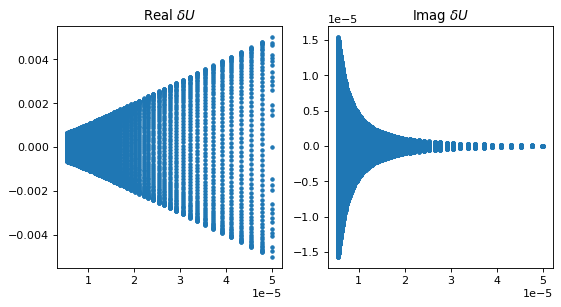

In [214]:
%matplotlib inline
import matplotlib.pyplot as plt

if __name__=='__main__':
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2)
    mask=(dist>1.1*a)&(dist<=10*a)
    ax[0].plot(dist[mask],np.real(unod[mask,2]),'.')
    ax[1].plot(dist[mask],np.imag(unod[mask,2]),'.')
    
    axs[0].set_title('Real $\delta U$')
    axs[1].set_title('Imag $\delta U$')

Solid Lines: M > 1; Dashed Lines: M = 1


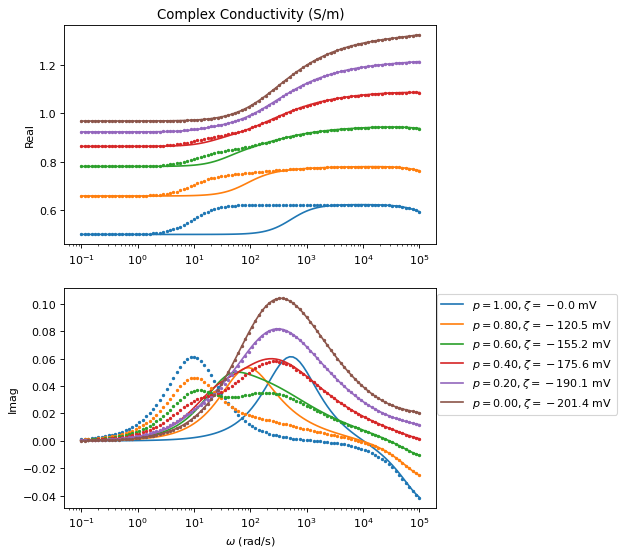

Check simulated potential with analytical solution


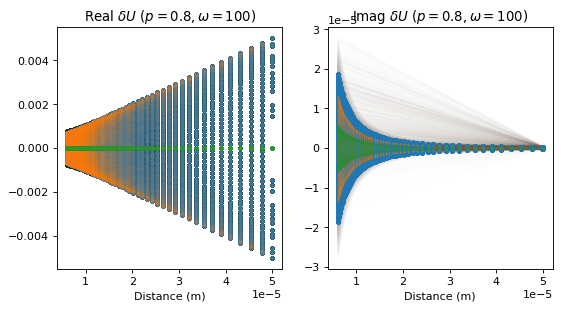

In [215]:
%matplotlib inline
import matplotlib.pyplot as plt
a=5e-6
e0=1e2
sigma_solid=-0.01
vol_frac=0.4
# vol_frac=1.0

def ansol_dipole(mesh,physics,freq,ratio,correction):
    #nodes=mesh['nodes']
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2)
    mask=dist>=a
    rho,theta,phi=cartesian2spherical(nodes[mask,0],nodes[mask,1],np.zeros(len(nodes[mask,0])))
    
    perm_electrolyte=perm0*80.0
    perm_solid=perm0*4.5
    #diffusion_electrolyte=2.0*1e-9
    #diffusion_stern=0.2*1e-9
    mobility_electrolyte=1.0*5e-8
    mobility_stern=0.1*5e-8
    sigma_electrolyte=-(1-ratio)*sigma_solid
    sigma_stern=-ratio*sigma_solid
    
    temp_K=293.0
    cinf=1.0e-2
    zval=1.0
    ze=zval*echarge
    debye_len=np.sqrt(perm_electrolyte*kB*temp_K/2/ze**2/kA/cinf)
    
    #diffusion coefficient based on Einstein relation
    diffusion_electrolyte=mobility_electrolyte*kB*temp_K/echarge
    diffusion_stern=mobility_stern*kB*temp_K/echarge
    
    #in case of Stern layer polarization only (ratio = 1.0)
    #zeta,sigma_electrolyte,cond_d,ccond_d are zero
    #in case of diffuse layer polarization only (ratio = 0.0)
    #sigma_stern,cond_s,ccond_s-ccond_solid are zero
    zeta=-2*kB*temp_K/ze*np.arcsinh(sigma_electrolyte/4/ze/kA/cinf/debye_len) #eq 27
    sigma_d_plus=2*ze*kA*cinf*debye_len*(np.exp(-ze*zeta/2/kB/temp_K)-1) #eq 26
    sigma_d_minus=-2*ze*kA*cinf*debye_len*(np.exp(ze*zeta/2/kB/temp_K)-1) #eq 26
    cond_d_plus=2*mobility_electrolyte*sigma_d_plus/a #eq 25
    cond_d_minus=-2*mobility_electrolyte*sigma_d_minus/a #eq 25
    cond_a=2*mobility_electrolyte*ze*kA*cinf #guess
    #cond_a=kA*cinf*ze**2/kB/temp_K*diffusion_electrolyte
    cond_d=cond_d_plus+cond_d_minus #eq 24
    cond_s=2*mobility_stern*sigma_stern/a  #eq 28
#     print('sigma_d_plus',sigma_d_plus)
#     print('sigma_d_minus',sigma_d_minus)
#     print('sigma_d',sigma_electrolyte,sigma_d_plus+sigma_d_minus)
#     print('cond_d_plus',cond_d_plus)
#     print('cond_d_minus',cond_d_minus)
#     print('zeta',zeta)
#     print('cond_a',cond_a)
#     print('cond_d',cond_d)
#     print('cond_s',cond_s)    
#     print('')
    cond_d=np.abs(cond_d) #eq 24
    cond_s=np.abs(cond_s) #eq 28
    
    #Stern layer polarization only
    if correction:
        kM=1+sigma_stern/2/ze/kA/cinf/np.cosh(ze*zeta/2/kB/temp_K)/debye_len #eq 32
    else:
        kM=1
    tau_s=a**2/2/diffusion_stern/kM #eq 31
    ccond_s=cond_s*1j*freq*tau_s/(1+1j*freq*tau_s)+1j*freq*perm_solid #Stern layer polarization only
    
    #diffuse layer polarization only
    dukhin=cond_d/2/cond_a #Dukhin number
    kS=(dukhin+1)*cond_a**2/(cond_d_plus+cond_a)/(cond_d_minus+cond_a) #eq 34
    tau_a=a**2*kS/2/diffusion_electrolyte #time constant
    reflection_d=(2*dukhin-1)/(2*dukhin+2)-1.5*kS*(cond_d_plus-cond_d_minus)**2/cond_a**2/\
        (2*dukhin+2)**2*(1-1j*freq*tau_a/(1+np.sqrt(1j*freq*tau_a/kS)+1j*freq*tau_a)) #eq 33
    ccond_a=cond_a+1j*freq*perm_electrolyte #complex conductivity of electrolyte
    ccond_d=ccond_a*(1+2*reflection_d)/(1-reflection_d) #diffuse layer polarization only
#     print('ccond_s-ccond_solid',ccond_s-1j*freq*perm_solid)
#     print('ccond_d',ccond_d)
#     print('')
    
    ccond_c=ccond_d+ccond_s
    reflection_c=(ccond_c-ccond_a)/(2*ccond_a+ccond_c)
    #unod=e0*(-rho+reflection_c*a*a**2/rho**2)*nodes[:,0]/rho

    unod=np.zeros(nodes.shape[0],dtype=complex)
    unod[mask]=e0*(-rho+reflection_c*a*a**2/rho**2)*nodes[mask,0]/rho
    
    ccond=(1+2*vol_frac*reflection_c)/(1-vol_frac*reflection_c) #eq 23
    return unod,ccond,zeta

if __name__=='__main__':
#     mesh=import_mesh('sphere_s61.hdf5')
#     physics=import_physics('sphere_s61.hdf5')
#     unod,cond,zeta=ansol_dipole(mesh,physics,freq=0.1,ratio=0.0)
    freqs=np.logspace(-1,5,100)
    ratios=np.arange(1.0,-0.2,-0.2)
    cond=np.zeros((len(ratios),len(freqs)),dtype=complex)
    zeta=np.zeros(len(ratios))
    for i in range(len(ratios)):
        for j in range(len(freqs)):
            ratio=ratios[i]
            freq=freqs[j]
            out1,out2,out3=ansol_dipole(mesh=[],physics=[],freq=freq,ratio=ratio,correction=True)
            cond[i,j]=out2
            zeta[i]=out3

    print('Solid Lines: M > 1; Dashed Lines: M = 1')
    labels=[]
    fig,ax=plt.subplots(2,1,figsize=(6,8),dpi=80)
    axs=ax.flatten()
    for i in range(len(ratios)):
        axs[0].plot(freqs,np.real(cond[i,:]),'-')
        axs[1].plot(freqs,np.imag(cond[i,:]),'-')
        labels.append('$p=%.2f,\zeta=%.1f$ mV'%(ratios[i],zeta[i]*1e3))
    
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    axs[0].set_ylabel('Real')
    axs[1].set_ylabel('Imag')
    axs[0].set_title('Complex Conductivity (S/m)')
    axs[1].set_xlabel('$\omega$ (rad/s)')
    axs[1].legend(labels,loc='upper right',bbox_to_anchor=(1.50,1.0))
    axs[0].axes.set_prop_cycle(None) #reset color cycle
    axs[1].axes.set_prop_cycle(None) #reset color cycle
    
    for i in range(len(ratios)):
        for j in range(len(freqs)):
            ratio=ratios[i]
            freq=freqs[j]
            out1,out2,out3=ansol_dipole(mesh=[],physics=[],freq=freq,ratio=ratio,correction=False)
            cond[i,j]=out2
            zeta[i]=out3

    for i in range(len(ratios)):
        axs[0].plot(freqs,np.real(cond[i,:]),'.',markersize=4)
        axs[1].plot(freqs,np.imag(cond[i,:]),'.',markersize=4)
    
    plt.show()
    
    print('Check simulated potential with analytical solution')
#     nodes=np.zeros((rho.shape[0],3))
#     nodes[:,0]=rho
    dist=np.sqrt(nodes[:,0]**2+nodes[:,1]**2)
    mask=(dist>=1.2*a)&(dist<=10*a)
    
    fig,ax=plt.subplots(1,2,figsize=(8,4),dpi=80)
    axs=ax.flatten()
    for i in range(len(ratios)):
        for j in range(len(freqs)):
            ratio=ratios[i]
            freq=freqs[j]
            ansol,out2,out3=ansol_dipole(mesh=[],physics=[],freq=freq,ratio=ratio,correction=True)
            #axs[0].plot(dist[mask],np.real(unod[mask,2]),'.')
            axs[0].plot(dist[mask],np.real(ansol[mask]),'.',alpha=0.01)
            #axs[0].plot(dist[mask],np.real(unod[mask,2]-ansol[mask]),'.')

            #axs[1].plot(dist[mask],np.imag(unod[mask,2]),'.')
            axs[1].plot(dist[mask],np.imag(ansol[mask]),'-',alpha=0.01)
            #axs[1].plot(dist[mask],np.imag(unod[mask,2]-ansol[mask]),'.')
    
    for i in range(1):
        for j in range(1):
            ratio=0.8
            freq=100
            ansol,out2,out3=ansol_dipole(mesh=[],physics=[],freq=freq,ratio=ratio,correction=True)
            #axs[0].plot(dist[mask],np.real(unod[mask,2]),'.')
            axs[0].plot(dist[mask],np.real(ansol[mask]),'.')
            axs[0].plot(dist[mask],np.real(unod[mask,2]),'.',alpha=0.1)
            axs[0].plot(dist[mask],np.real(unod[mask,2]-ansol[mask]),'.',alpha=0.1)
            #axs[0].plot(dist[mask],np.real(unod[mask,2]-ansol[mask]),'.')

            #axs[1].plot(dist[mask],np.imag(unod[mask,2]),'.')
            axs[1].plot(dist[mask],np.imag(ansol[mask]),'.')
            axs[1].plot(dist[mask],np.imag(unod[mask,2]),'.',markersize=1,alpha=0.1)
            axs[1].plot(dist[mask],np.imag(unod[mask,2]-ansol[mask]),'.',markersize=1,alpha=0.1)
            #axs[1].plot(dist[mask],np.imag(unod[mask,2]-ansol[mask]),'.')
    
    axs[0].set_xlabel('Distance (m)')
    axs[1].set_xlabel('Distance (m)')
    axs[0].set_title('Real $\delta U$ ($p=0.8,\omega=100$)')
    axs[1].set_title('Imag $\delta U$ ($p=0.8,\omega=100$)')